In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import copy

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 46 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# Function to pick a random source center inside the Einstein Radius of the lens
def pick_centers(kwargs_lens):
    radius = kwargs_lens['theta_E']
    c1, c2 = random.uniform(0, 1)*radius, random.uniform(0, 1)*radius
    d = np.sqrt(c1**2 + c2**2)
    while(d > radius):
        c1, c2 = random.uniform(0, 1)*radius, random.uniform(0, 1)*radius
        d = np.sqrt(c1**2 + c2**2)
    return c1, c2

In [4]:
#Writes 3 files for each simulation (one for each band). Folder is the ID, name n_g.fits
def write_files(ID, image_g, image_r, image_i):
    path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim/'
    folder = str(ID)
    if not os.path.exists(path + folder):
        os.makedirs(path + folder)
        n = 0
    else:
        n = len(os.listdir(path + folder))/3 #/3
    hdu = fits.PrimaryHDU(image_g)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_g.fits')
    
    hdu = fits.PrimaryHDU(image_r)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_r.fits')
    
    hdu = fits.PrimaryHDU(image_i)
    hdul = fits.HDUList([hdu])
    hdul.writeto(path + folder + '/' + str(int(n+1)) + '_i.fits')

In [5]:
# Color distribution
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
path = path + 'color_distribution/source_colors.csv'
colors = pd.read_csv(path)
colors = colors[colors['DNF_ZMEAN_MOF'] > 0.01] #When there is no data z<0
colors = colors[colors['MAG_PSF_G'] < 30.] [colors['MAG_PSF_R'] < 30.] [colors['MAG_PSF_I'] < 30.] #decent magnitude
colors['g_r'] = colors['MAG_PSF_G'] - colors['MAG_PSF_R'] # g-r color
colors['r_i'] = colors['MAG_PSF_R'] - colors['MAG_PSF_I'] # r-i color

dz = 0.2 # Range of redshift for filtering
dm = 0.3 # Range of magnitude for filtering

def color_distribution(z, m):
    #objects with a redshift between z - dz and z + dz, same idea for apparent magnitude
    fcolors = colors[(colors['DNF_ZMEAN_MOF'] > z - dz)] [(colors['DNF_ZMEAN_MOF'] < z + dz)] 
    fcolors = fcolors[(colors['MAG_PSF_G'] > m - dm)] [(colors['MAG_PSF_G'] < m + dm)]
    random_object = fcolors.sample()
    g_r = random_object['g_r'].values[0]
    r_i = random_object['r_i'].values[0]
    return(g_r, r_i)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
def simulation(radii, redshifts, sigma, lens_ellip, magnitudes, double, i):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [redshifts['source1']],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source1']} 
                           #and also serves as the redshift of lensed point sources}

    if(double == True):
        kwargs_model_physical['source_light_model_list'].append('SERSIC')
        kwargs_model_physical['source_redshift_list'].append(redshifts['source2'])
        kwargs_model_physical['z_source'] = redshifts['source2']
        
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': sigma, 'center_x': 0, 'center_y': 0, 
                    'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #cut on the Einstein radius of the lens
    if(kwargs_lens[0]['theta_E'] < 0.35):
        return None
    
    #print(kwargs_lens[0]['theta_E'])
    
    #First source light distributions
    m1 = random.uniform(magnitudes['m1_min'], random.uniform(magnitudes['m1_max1'], magnitudes['m1_max2']))
    r1, n1 = random.uniform(0.2, 0.4), random.uniform(1.2, 1.7)
    #colors of the other bands for each source
    g_r_source_1, r_i_source_1 = color_distribution(redshifts['source1'], m1)
    #Pick center of first source inside the lens Einstein Radius
    c1x, c1y = pick_centers(kwargs_lens[0])
    #First source light:
    kwargs_source_mag_g_1 = [{'magnitude': m1, 'R_sersic': r1, 'n_sersic': n1, 'e1': 0., 'e2': 0.,
                              'center_x': c1x, 'center_y': c1y}]
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r_1 = copy.deepcopy(kwargs_source_mag_g_1)
    kwargs_source_mag_r_1[0]['magnitude'] -= g_r_source_1
    kwargs_source_mag_i_1 = copy.deepcopy(kwargs_source_mag_r_1)
    kwargs_source_mag_i_1[0]['magnitude'] -= r_i_source_1
    #Same for second source
    if(double == True):
        m2, r2, n2 = random.uniform(m1, magnitudes['m2_max']), random.uniform(0.2, 0.4), random.uniform(1.2, 1.7)
        g_r_source_2, r_i_source_2 = color_distribution(redshifts['source2'], m2)
        c2x, c2y = pick_centers(kwargs_lens[0])
        kwargs_source_mag_g_2 = [{'magnitude': m2, 'R_sersic': r2, 'n_sersic': n2, 
                              'center_x': c2x, 'center_y': c2y}]
        kwargs_source_mag_r_2 = copy.deepcopy(kwargs_source_mag_g_2)
        kwargs_source_mag_r_2[0]['magnitude'] -= g_r_source_2
        kwargs_source_mag_i_2 = copy.deepcopy(kwargs_source_mag_r_2)
        kwargs_source_mag_i_2[0]['magnitude'] -= r_i_source_2
        
    kwargs_source_mag_g = kwargs_source_mag_g_1 + kwargs_source_mag_g_2 if(double) else kwargs_source_mag_g_1 
    kwargs_source_mag_r = kwargs_source_mag_r_1 + kwargs_source_mag_r_2 if(double) else kwargs_source_mag_r_1 
    kwargs_source_mag_i = kwargs_source_mag_i_1 + kwargs_source_mag_i_2 if(double) else kwargs_source_mag_i_1 
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    image_g = image_g[::-1]
    image_r = image_r[::-1]
    image_i = image_i[::-1]
    
    write_files(i, image_g, image_r, image_i)  
    
    #"""
    title = "z1 = {:.2f}, m1 = {:.2f}, theta E = {:.2f}, ".format(redshifts['source1'], m1, kwargs_lens[0]['theta_E'])
    title = title + 'c1x = {:.2f}, c2y = {:.2f}'.format(c1x, c1y)
    new_title = "{:.2f},{:.2f},{:.2f},".format(redshifts['source1'], m1, kwargs_lens[0]['theta_E'])
    new_title = new_title + "{:.2f},{:.2f},".format(c1x, c1y)
    print(new_title)
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    plt.figure()
    plt.imshow(rgb)
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])
    path_plot = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim/'
    #plt.savefig(path_plot + 'Image' + str(i) + '.png', bbox_inches='tight')
    plt.show(block=True)
    #plt.close()
    #"""
    radii.append(kwargs_lens[0]['theta_E'])

In [7]:
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
complete_data = pd.read_csv(path + 'Data/all_data_sim.csv')
print(len(complete_data))
data = complete_data.sample(n = 500, replace = True) 
data.head(2)

19727


,COADD_OBJECT_ID,PIXEL,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I
13638,349774888,74606769,19.957279,4.645897,-0.120465,-0.034494,0.554303,185.76508,1.12051,0.893905,0.843243
13916,77604211,71660280,32.151900,-9.189696,-0.176491,0.030878,0.542141,233.88385,1.10349,0.949258,0.891141


In [8]:
radii = []
def simulations_from_data(num_max, double):
    complete_data = pd.read_csv(path + 'Data/all_data_sim.csv')
    #data = complete_data.sample(frac=1).reset_index() #(n = 30000, replace = True)
    for index, row in complete_data.iterrows():
        if index == num_max:
            break
        DES_g_band_obs['seeing'] = row['FWHM_WMEAN_G'] 
        DES_r_band_obs['seeing'] = row['FWHM_WMEAN_R']
        DES_i_band_obs['seeing'] = row['FWHM_WMEAN_I']
        
        coadd_id = int(row['COADD_OBJECT_ID'])
        z_lens = row['Z']
        z_source1 = random.uniform(z_lens, z_lens + 0.7) # 0.35
        z_source2 = random.uniform(z_source1, z_source1 + 0.35) # 0.35
        redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
        dispersion = row['VEL_DISP']
        magnitudes = {'m1_min': 22, 'm1_max1':24.8, 'm1_max2':25.0, 'm2_max':26.2}
    
        angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
        angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
        ratio = random.uniform(0.001, 1) #distribution for the axis ratio
        e1, e2 = param.phi_q2_ellipticity(angle, ratio)
        lens_ellip = [e1, e2]
    
        simulation(radii, redshifts, dispersion, lens_ellip, magnitudes, double , coadd_id)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


0.88,23.09,1.10,0.61,0.30,


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in log10


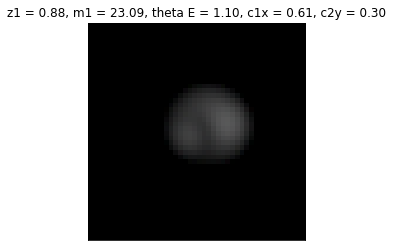

1.26,23.81,0.94,0.17,0.27,


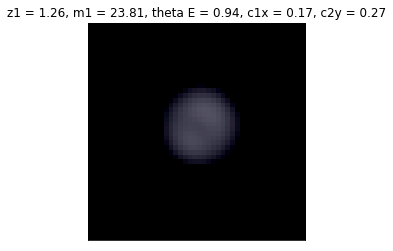

0.62,24.12,0.73,0.11,0.30,


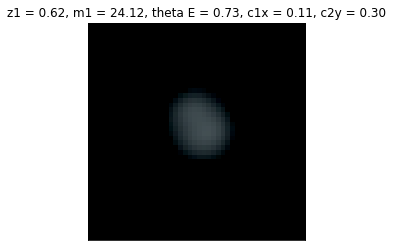

1.28,22.95,0.79,0.03,0.44,


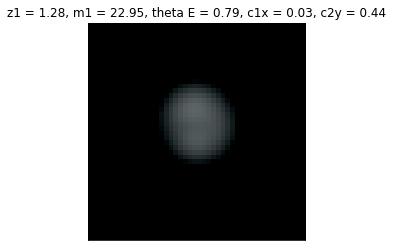

0.73,22.56,0.61,0.03,0.23,


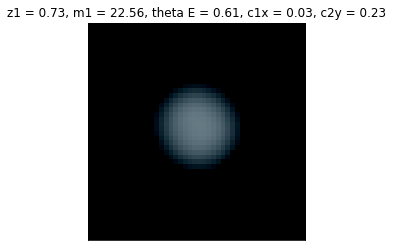

0.69,23.52,0.39,0.07,0.14,


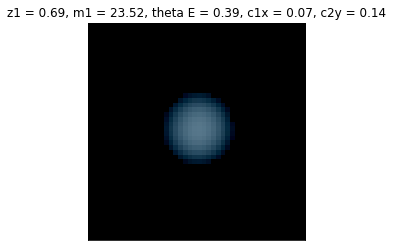

0.60,24.07,1.11,0.23,0.86,


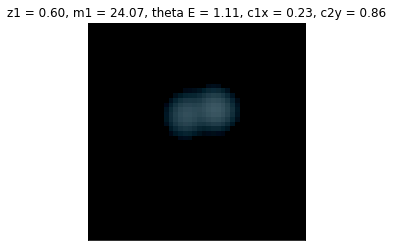

1.07,24.16,0.75,0.21,0.18,


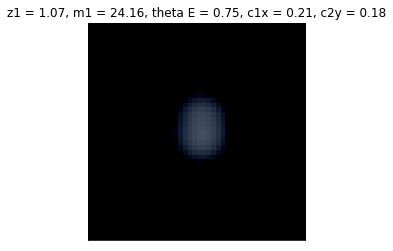

1.12,24.19,0.76,0.35,0.03,


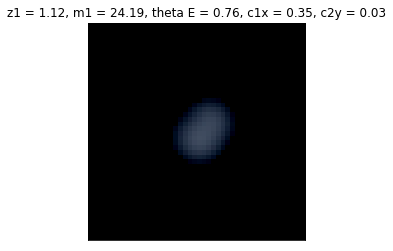

0.38,23.91,0.87,0.03,0.16,


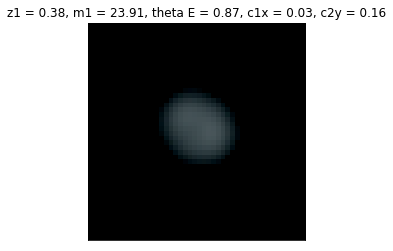

0.84,22.33,1.52,1.08,0.29,


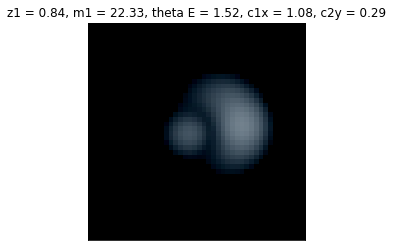

0.84,23.92,0.79,0.50,0.15,


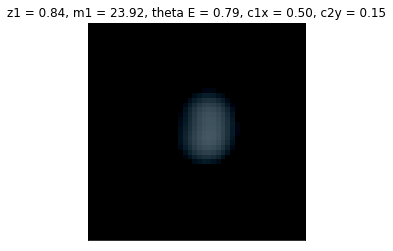

1.11,22.89,0.46,0.12,0.19,


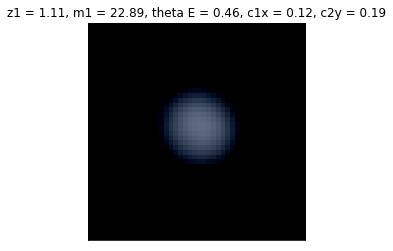

0.68,23.22,0.39,0.16,0.01,


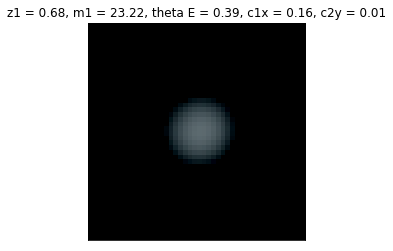

0.93,22.08,0.40,0.38,0.09,


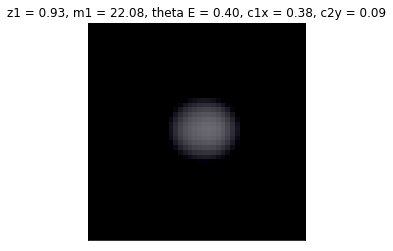

0.47,23.58,0.43,0.30,0.10,


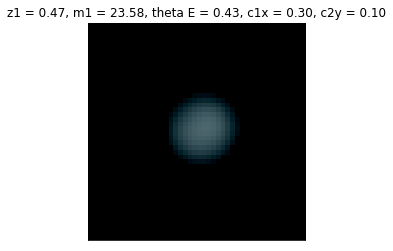

1.09,22.31,0.56,0.16,0.09,


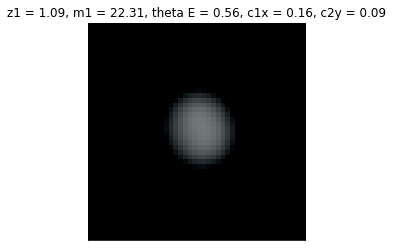

1.11,24.50,0.76,0.17,0.32,


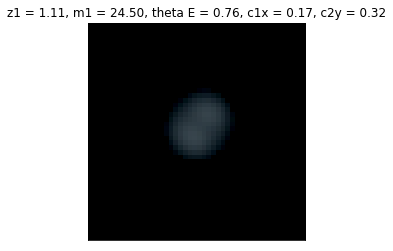

1.03,24.58,0.48,0.36,0.13,


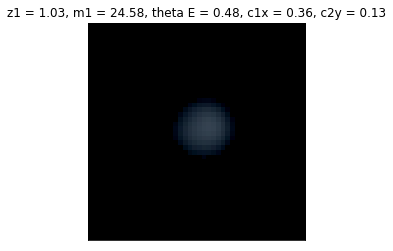

0.71,24.51,0.48,0.37,0.02,


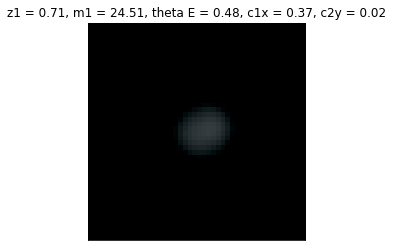

0.53,24.64,0.39,0.16,0.11,


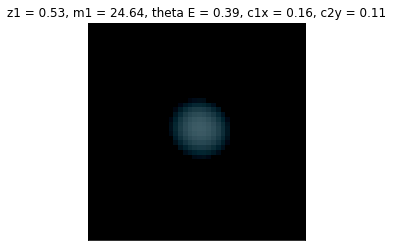

0.66,22.29,0.77,0.06,0.12,


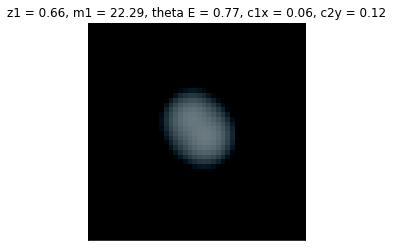

0.96,22.68,0.68,0.43,0.47,


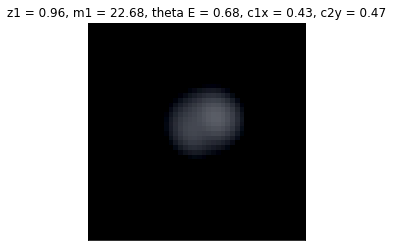

1.13,23.07,0.78,0.48,0.23,


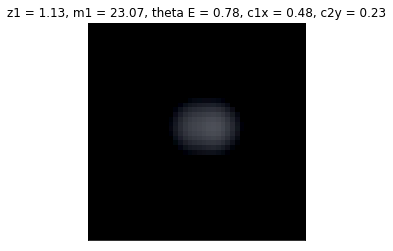

1.11,24.81,0.59,0.32,0.15,


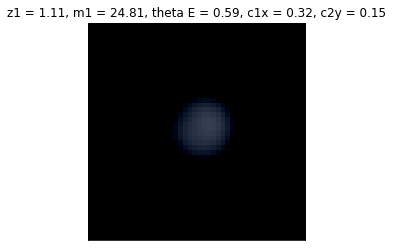

0.91,24.11,1.30,0.23,0.00,


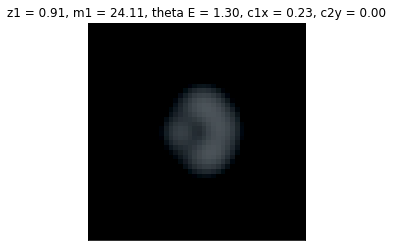

1.11,24.74,0.71,0.17,0.25,


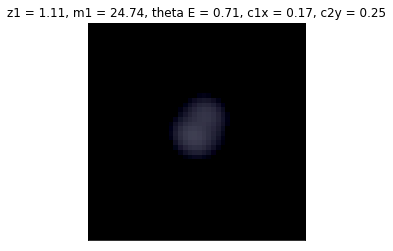

0.73,22.19,0.82,0.21,0.24,


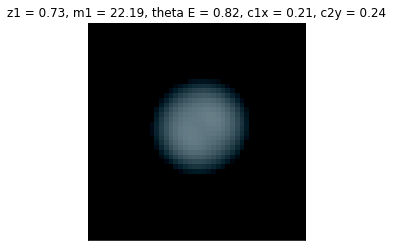

1.10,24.07,0.47,0.07,0.21,


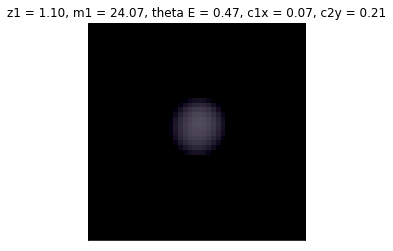

0.95,23.82,1.11,0.53,0.30,


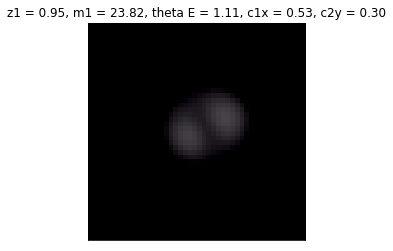

0.67,24.36,0.78,0.38,0.51,


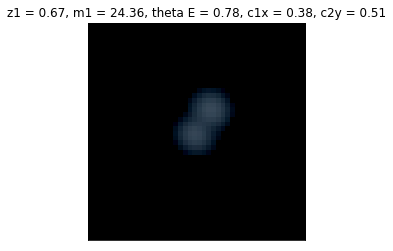

0.81,22.28,0.95,0.16,0.48,


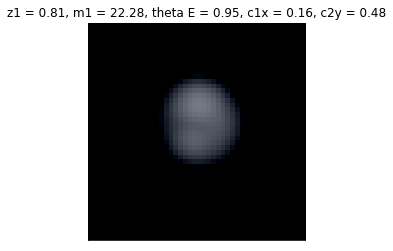

0.98,24.32,0.69,0.40,0.01,


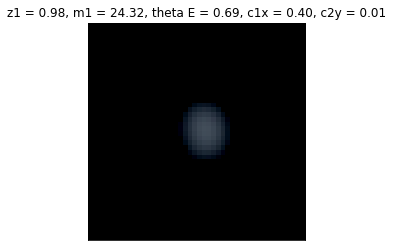

0.91,23.95,1.20,0.53,0.84,


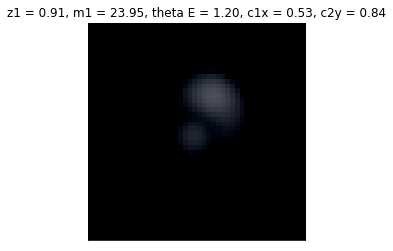

0.58,24.92,0.46,0.28,0.19,


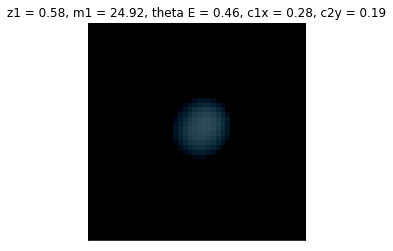

0.89,23.30,0.72,0.68,0.11,


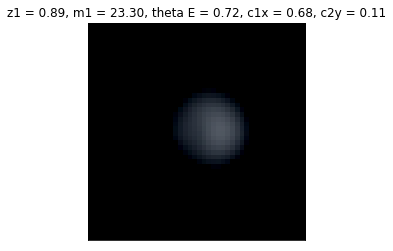

0.94,24.25,1.08,0.33,0.99,


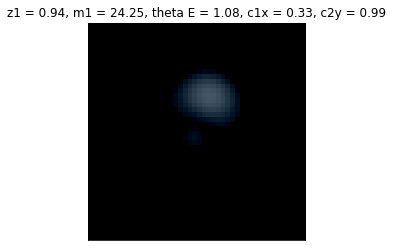

0.92,24.01,0.63,0.28,0.22,


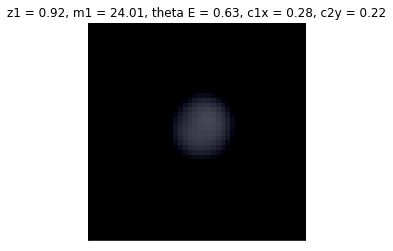

0.70,23.09,0.42,0.22,0.29,


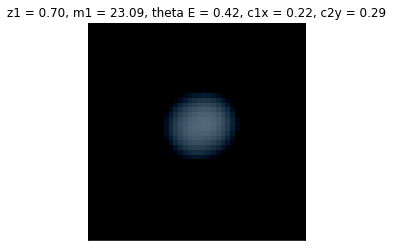

1.16,22.66,0.58,0.07,0.37,


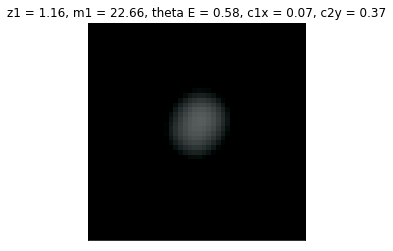

0.97,23.53,0.45,0.43,0.10,


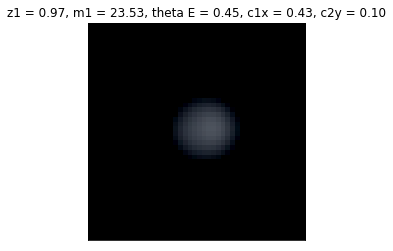

0.76,23.20,0.64,0.14,0.24,


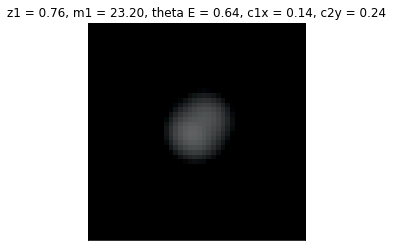

0.79,24.85,0.48,0.14,0.19,


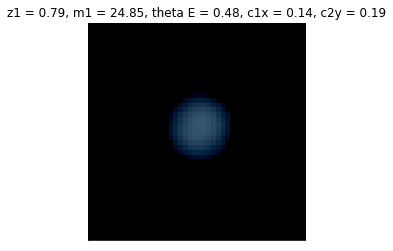

1.02,22.81,0.63,0.32,0.23,


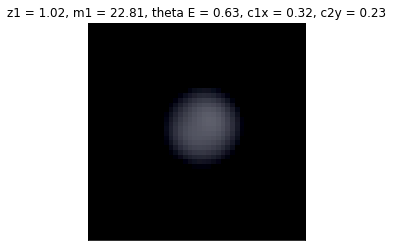

0.62,22.79,0.35,0.05,0.12,


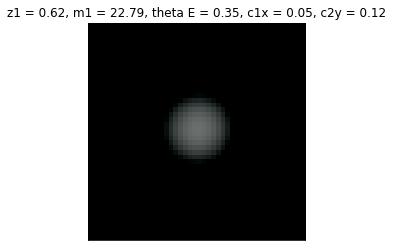

0.70,23.94,0.69,0.05,0.42,


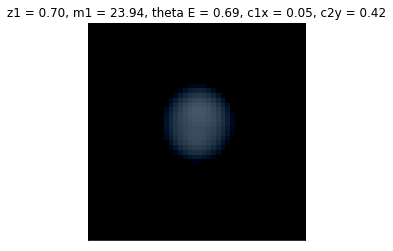

0.89,23.82,0.48,0.42,0.14,


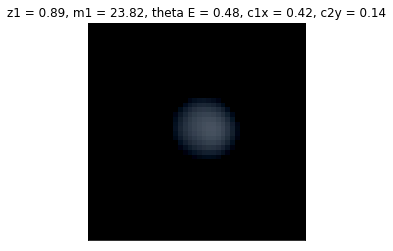

0.87,23.96,0.78,0.40,0.01,


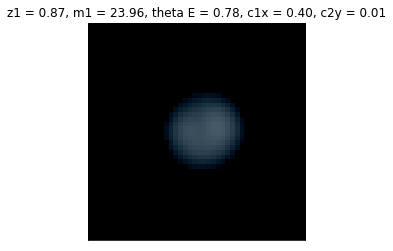

0.93,23.18,0.42,0.25,0.30,


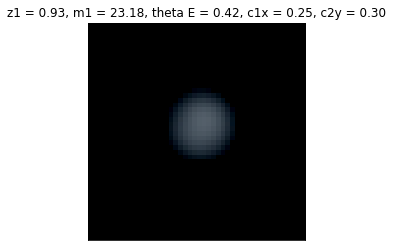

0.44,22.37,0.38,0.08,0.04,


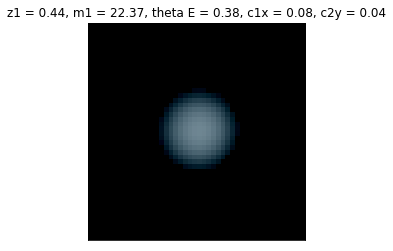

0.83,24.30,1.33,0.52,0.58,


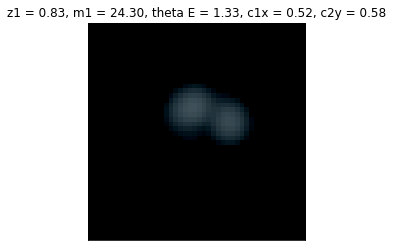

1.21,22.55,0.94,0.78,0.51,


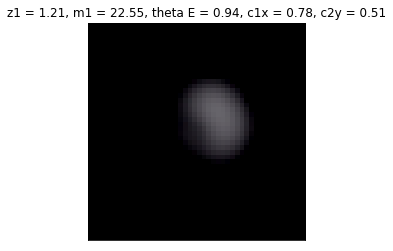

1.01,24.57,0.69,0.39,0.24,


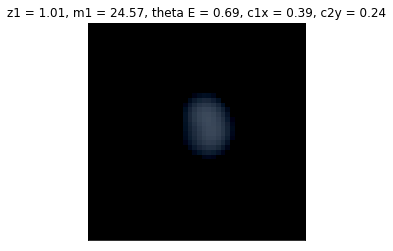

0.88,23.59,0.40,0.13,0.08,


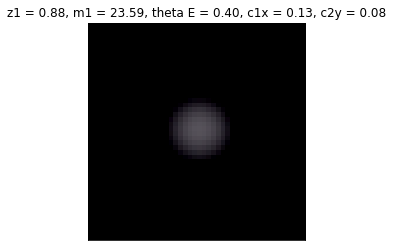

1.17,22.21,1.58,0.68,0.95,


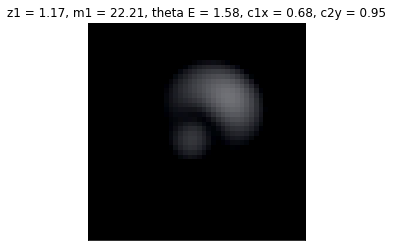

0.59,23.14,0.36,0.16,0.00,


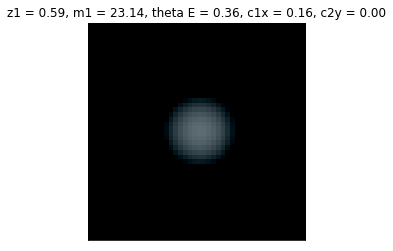

1.18,24.68,1.27,0.06,0.34,


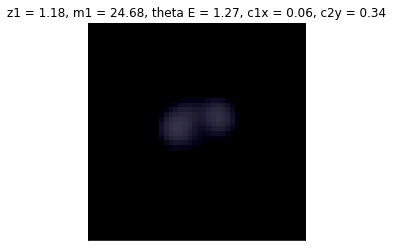

0.92,23.21,0.75,0.38,0.30,


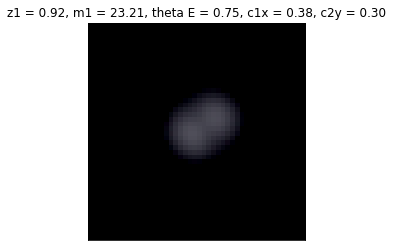

0.65,22.13,0.81,0.36,0.61,


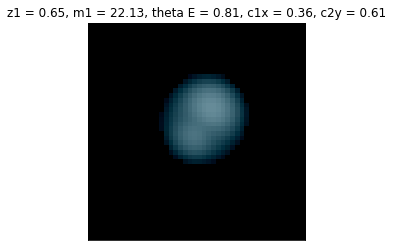

0.55,22.73,0.98,0.53,0.56,


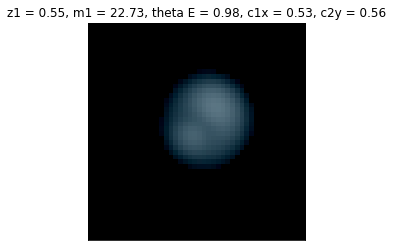

0.69,23.37,0.57,0.33,0.15,


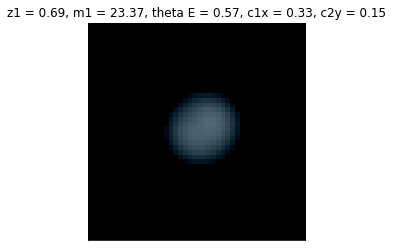

0.87,22.38,0.49,0.43,0.12,


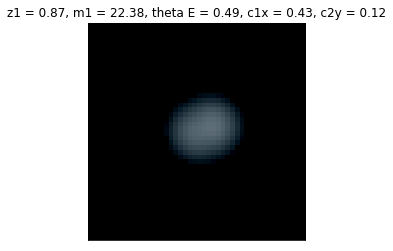

0.91,23.09,0.78,0.75,0.02,


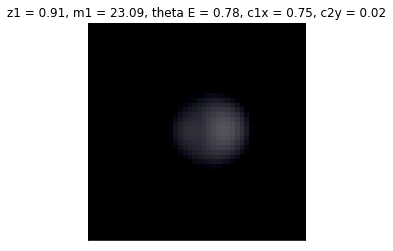

0.55,22.07,1.08,0.12,0.15,


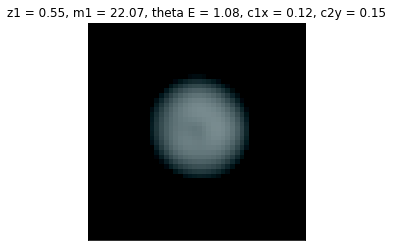

0.77,22.90,1.05,0.89,0.50,


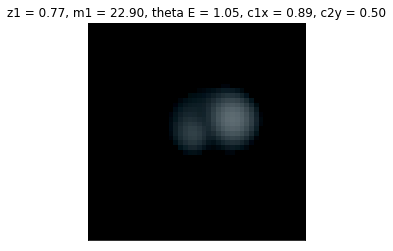

1.06,22.98,0.56,0.04,0.40,


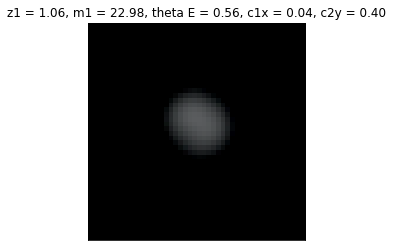

1.00,24.84,0.77,0.32,0.35,


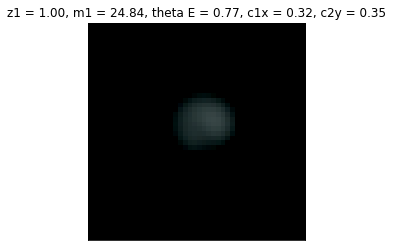

1.17,22.32,0.98,0.31,0.09,


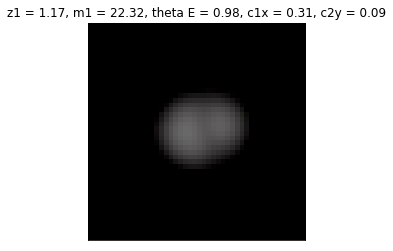

0.73,22.65,0.50,0.08,0.31,


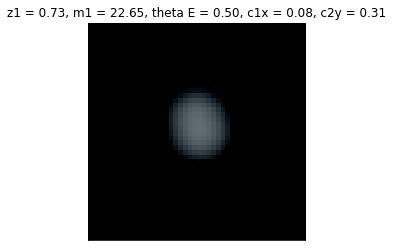

0.83,22.92,0.69,0.11,0.26,


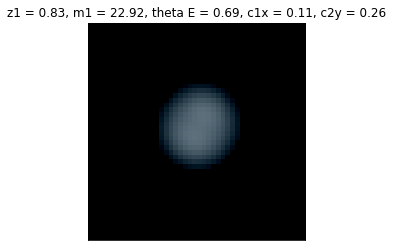

0.43,23.13,0.56,0.16,0.23,


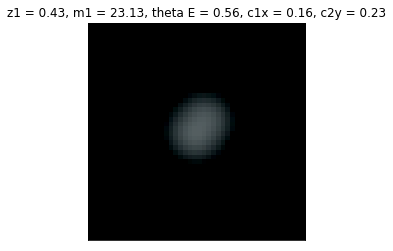

0.88,23.27,0.39,0.33,0.19,


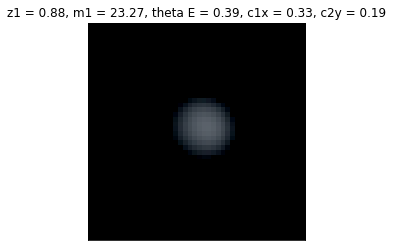

0.79,22.44,0.52,0.39,0.15,


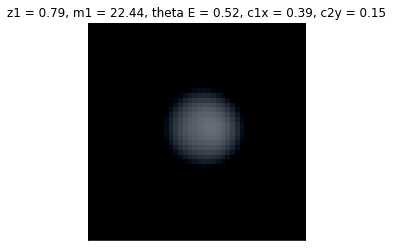

0.83,24.42,0.77,0.67,0.34,


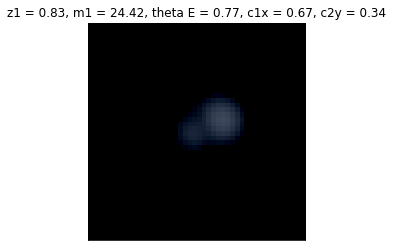

0.86,24.11,0.72,0.36,0.23,


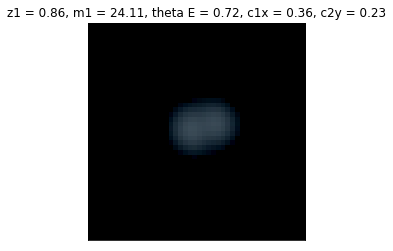

0.90,23.99,1.31,0.28,0.56,


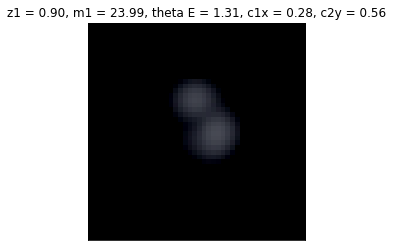

0.70,24.63,0.53,0.24,0.30,


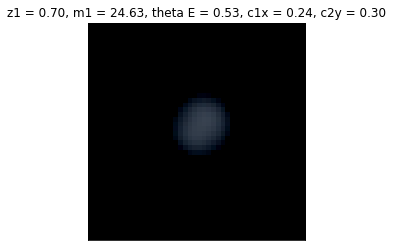

1.17,22.84,0.68,0.65,0.04,


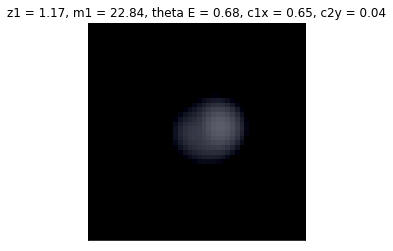

1.00,24.42,0.45,0.07,0.14,


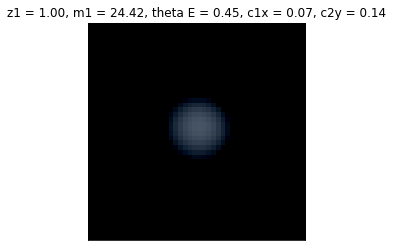

0.85,24.16,0.89,0.12,0.58,


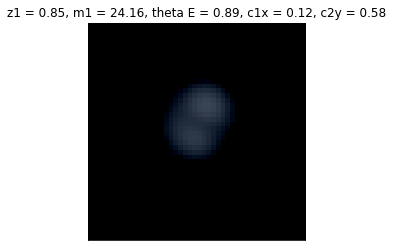

1.09,22.33,0.38,0.23,0.26,


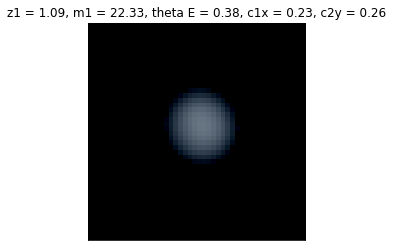

0.89,23.86,1.40,0.88,0.60,


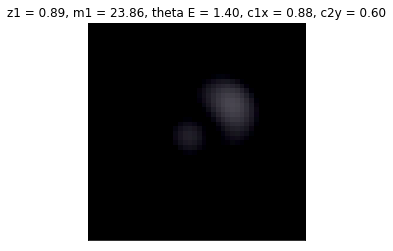

0.83,23.62,0.40,0.03,0.28,


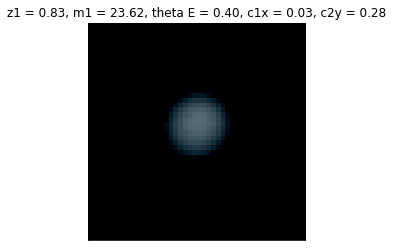

0.77,24.47,0.67,0.55,0.01,


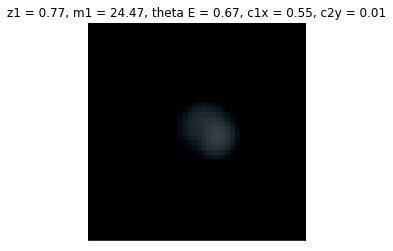

1.10,22.23,0.71,0.04,0.66,


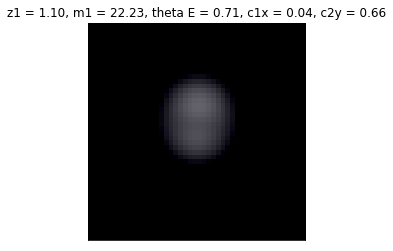

0.63,22.74,0.81,0.60,0.30,


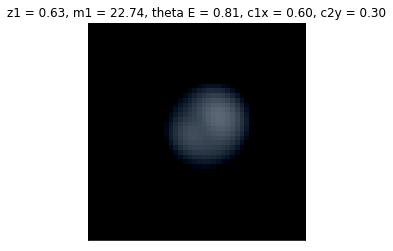

0.86,22.71,1.52,0.85,0.03,


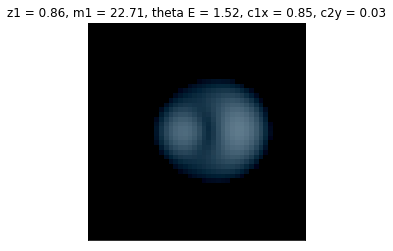

1.17,22.76,0.86,0.53,0.65,


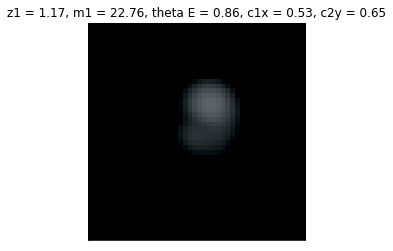

0.91,24.42,0.79,0.69,0.07,


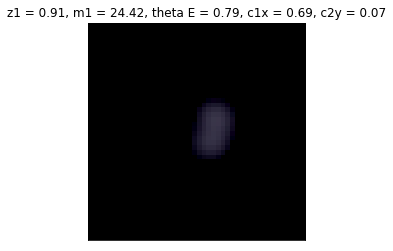

1.28,24.43,1.23,0.49,0.73,


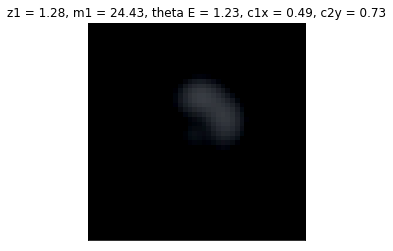

0.86,23.00,0.76,0.18,0.00,


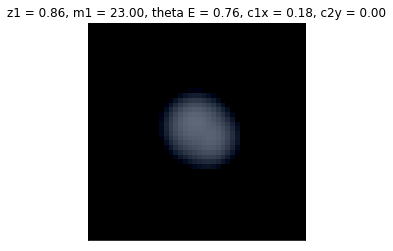

0.86,24.02,0.68,0.35,0.38,


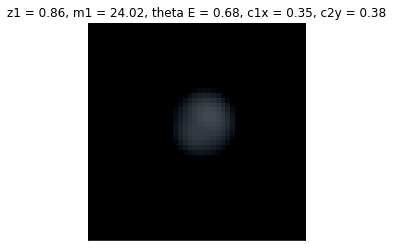

1.19,22.45,1.25,0.48,0.78,


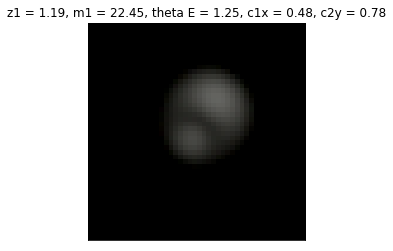

0.70,22.83,0.53,0.29,0.27,


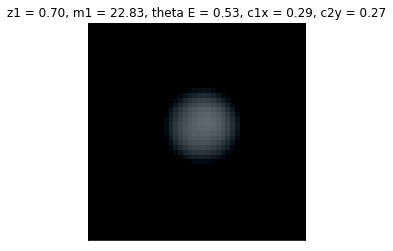

0.72,22.48,0.55,0.29,0.40,


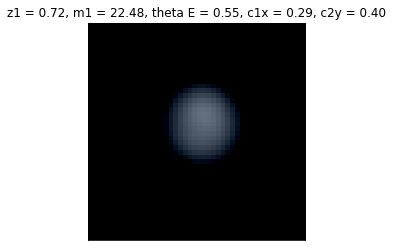

0.38,24.61,0.55,0.17,0.25,


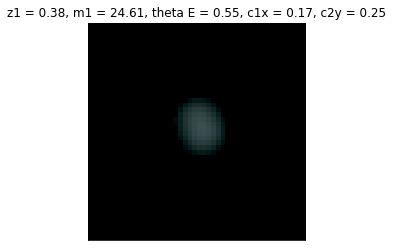

1.22,22.55,0.78,0.41,0.00,


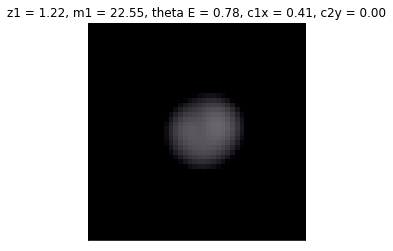

1.16,23.65,0.90,0.51,0.59,


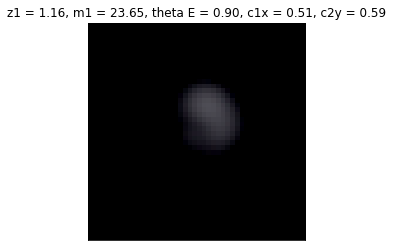

0.83,22.82,0.48,0.30,0.01,


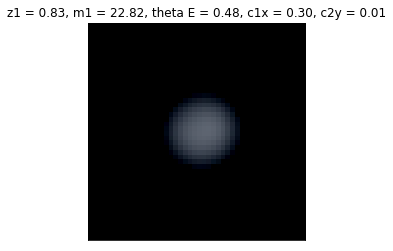

0.61,23.51,0.69,0.38,0.37,


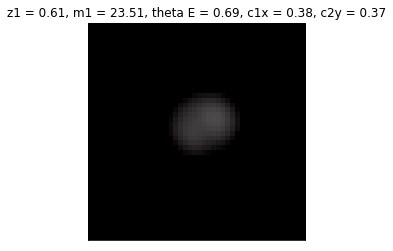

1.10,22.05,0.88,0.05,0.75,


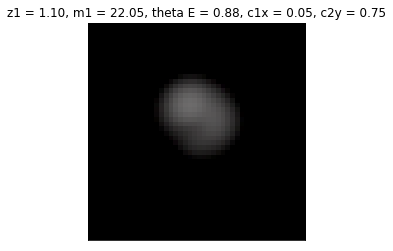

1.11,23.15,0.59,0.22,0.36,


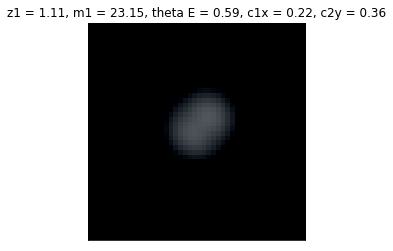

1.12,24.84,0.85,0.10,0.61,


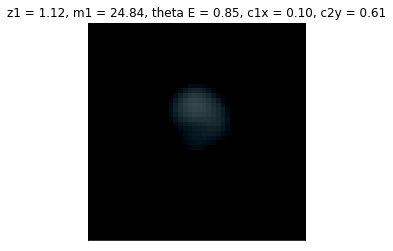

1.03,22.19,0.57,0.25,0.33,


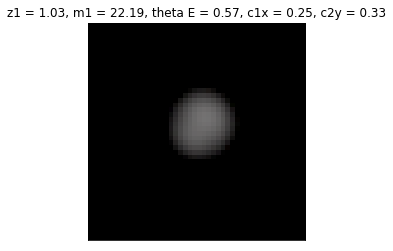

0.64,24.26,0.50,0.38,0.26,


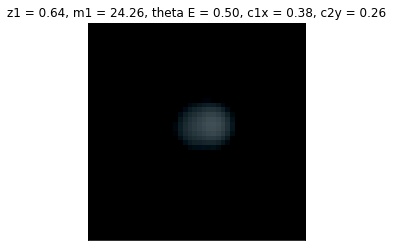

0.67,24.16,0.41,0.09,0.21,


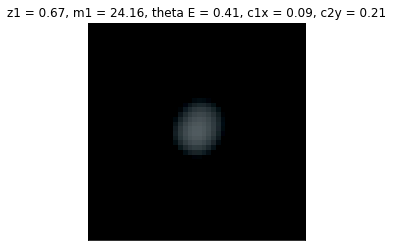

0.49,23.80,0.90,0.12,0.02,


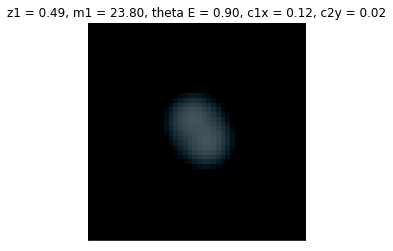

0.80,23.67,1.82,1.07,1.01,


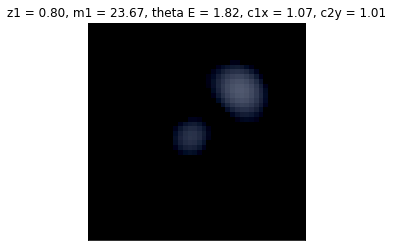

1.12,23.73,0.47,0.26,0.25,


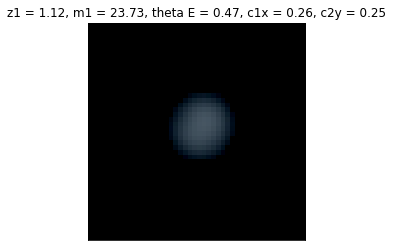

0.84,23.90,1.05,0.86,0.17,


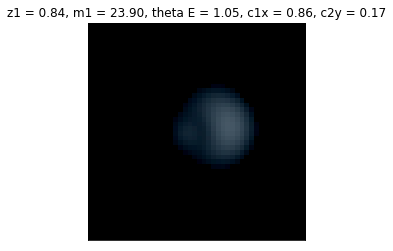

0.74,24.72,0.39,0.09,0.16,


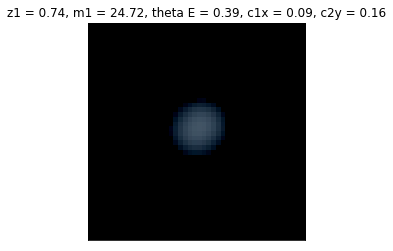

0.56,24.08,0.84,0.63,0.47,


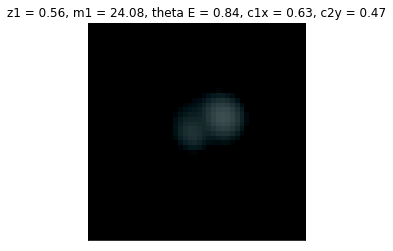

0.59,24.30,0.40,0.18,0.32,


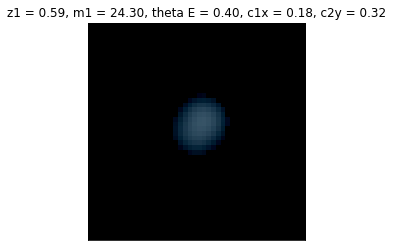

0.98,22.95,0.42,0.13,0.03,


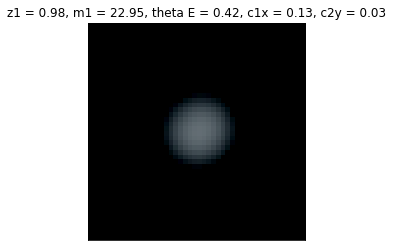

0.98,24.76,0.70,0.02,0.18,


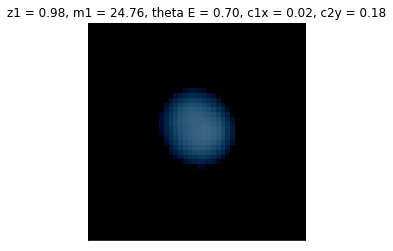

1.12,22.37,0.52,0.46,0.24,


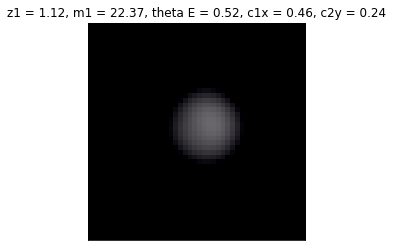

0.83,22.53,0.43,0.23,0.30,


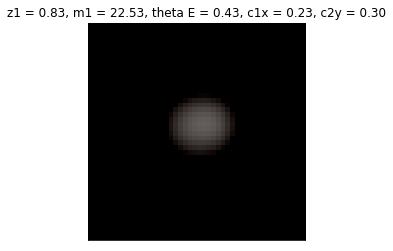

1.04,22.28,0.50,0.14,0.19,


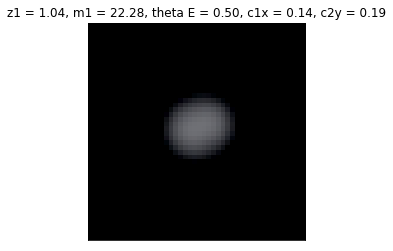

0.96,24.20,1.06,0.40,0.45,


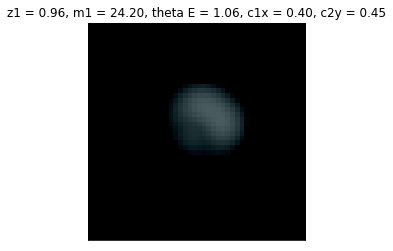

0.35,24.06,0.74,0.09,0.13,


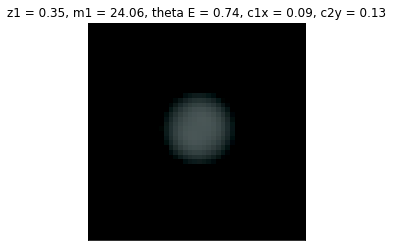

1.10,22.15,0.41,0.09,0.21,


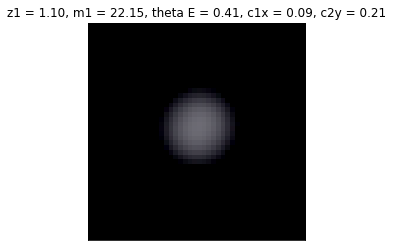

0.68,24.67,0.84,0.36,0.23,


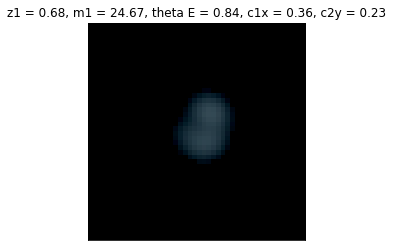

0.91,23.20,1.01,0.60,0.52,


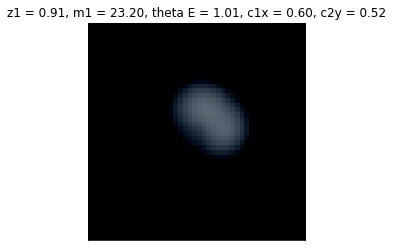

1.08,22.51,0.62,0.01,0.28,


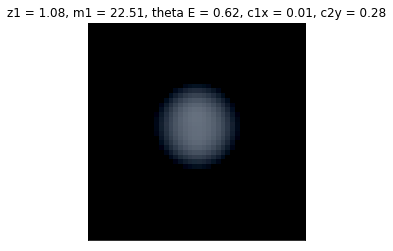

0.70,24.48,0.41,0.21,0.08,


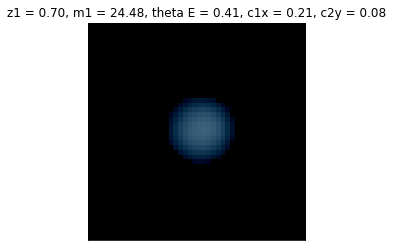

0.38,22.75,0.60,0.42,0.18,


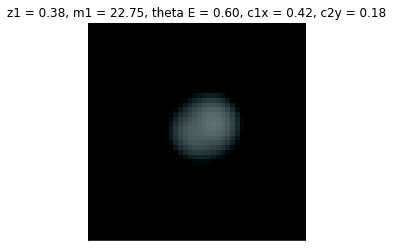

0.76,22.45,0.56,0.19,0.29,


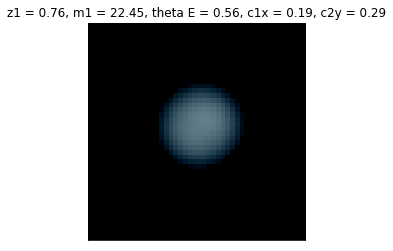

1.07,22.89,0.60,0.01,0.40,


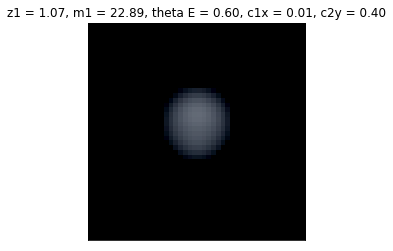

0.94,24.64,1.03,0.29,0.13,


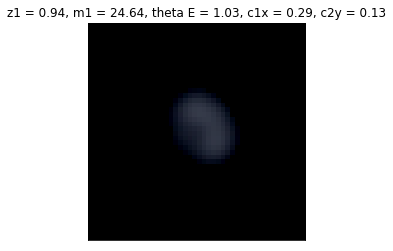

1.03,23.57,0.79,0.50,0.42,


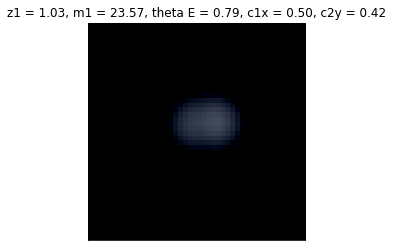

1.09,23.70,1.04,0.84,0.17,


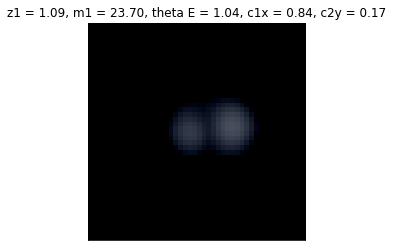

1.18,23.30,0.69,0.18,0.11,


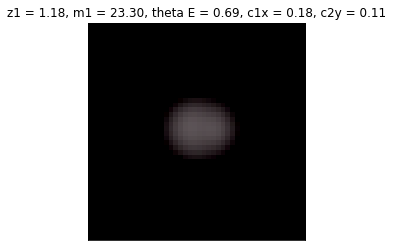

0.56,24.47,0.43,0.15,0.04,


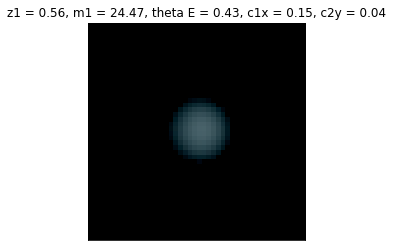

0.80,24.31,0.52,0.20,0.01,


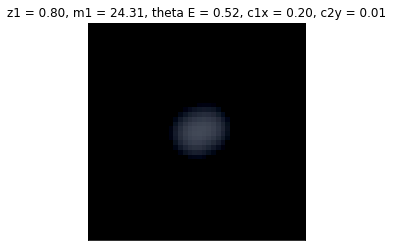

0.74,22.37,0.54,0.00,0.22,


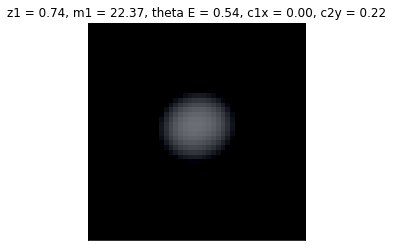

0.59,23.90,0.36,0.28,0.00,


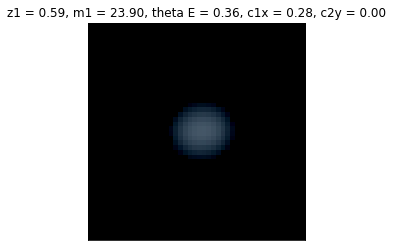

0.83,22.62,1.01,0.42,0.88,


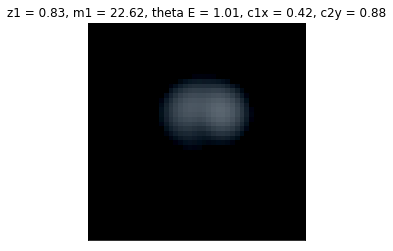

1.16,22.17,0.50,0.17,0.32,


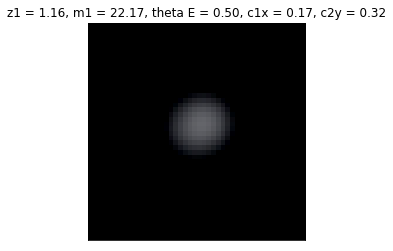

0.80,24.36,0.47,0.38,0.01,


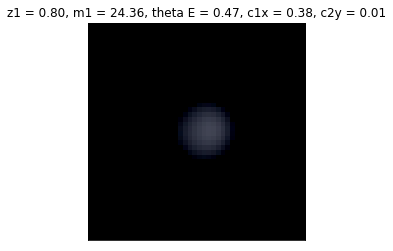

0.94,22.90,1.05,0.75,0.30,


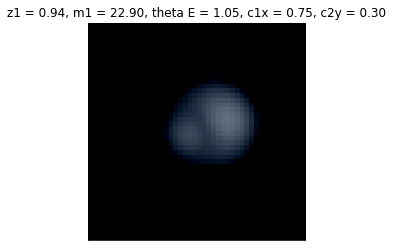

1.01,22.35,0.67,0.31,0.20,


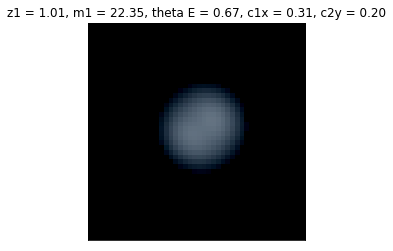

0.49,24.19,0.69,0.22,0.28,


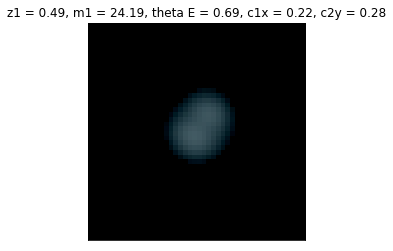

0.55,22.97,0.41,0.04,0.36,


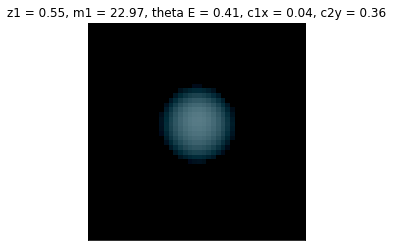

0.96,23.53,0.47,0.21,0.02,


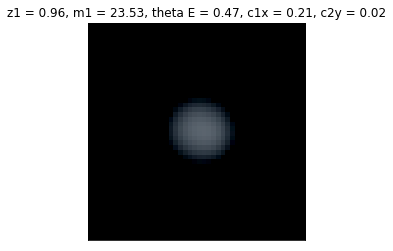

0.93,23.43,0.82,0.17,0.56,


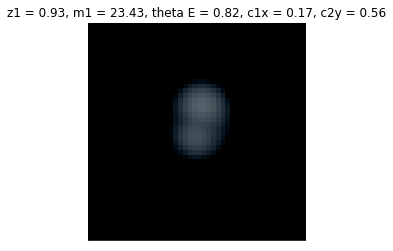

1.06,23.15,0.94,0.02,0.42,


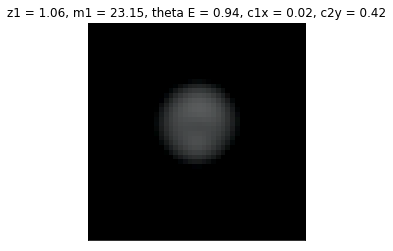

1.33,24.91,1.13,0.48,0.16,


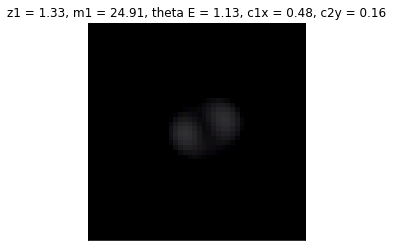

1.36,23.83,4.09,3.38,1.62,


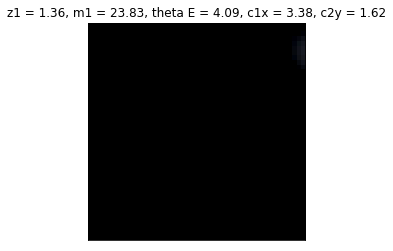

0.89,22.75,1.56,0.07,0.63,


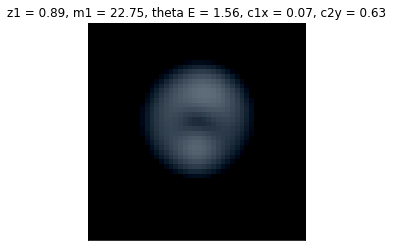

0.79,24.15,0.96,0.05,0.12,


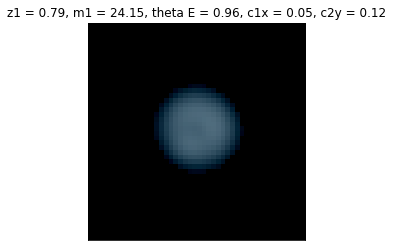

0.82,24.64,0.69,0.35,0.54,


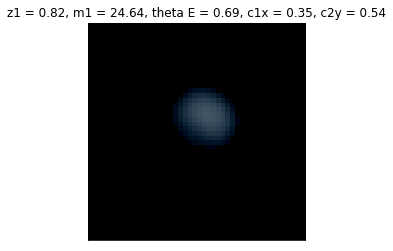

0.81,23.55,0.41,0.15,0.27,


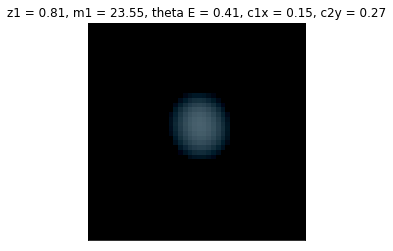

1.24,22.27,0.60,0.22,0.39,


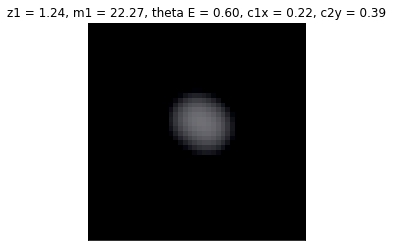

0.85,24.88,0.40,0.34,0.16,


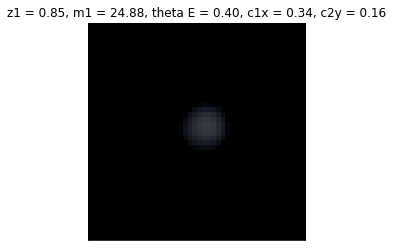

0.99,23.83,0.67,0.16,0.17,


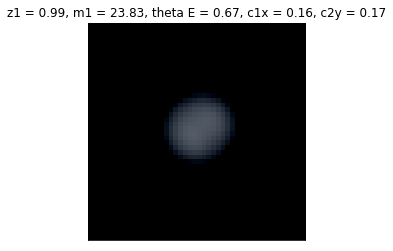

1.18,24.25,0.87,0.45,0.19,


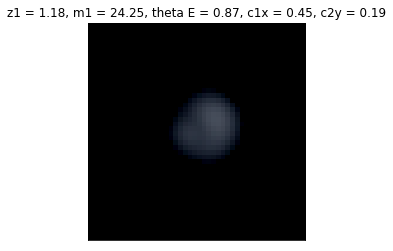

1.30,24.31,0.49,0.23,0.40,


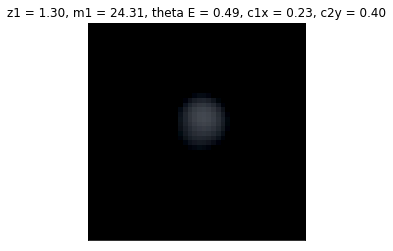

1.13,23.23,0.57,0.34,0.19,


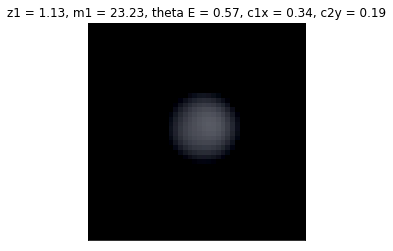

0.91,22.74,0.96,0.21,0.83,


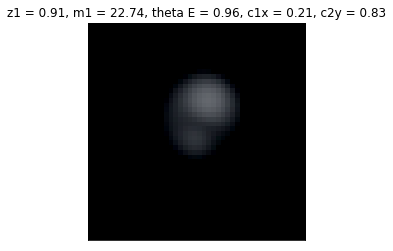

0.87,24.49,0.45,0.33,0.21,


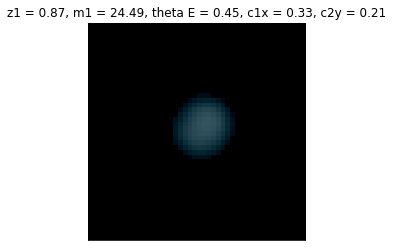

0.60,22.72,0.52,0.41,0.22,


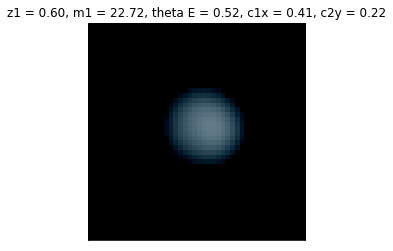

0.73,23.94,0.79,0.20,0.19,


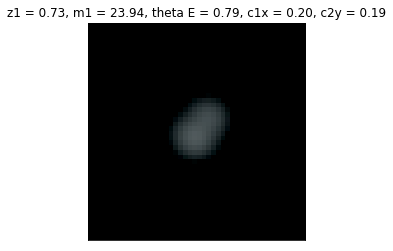

1.12,23.99,0.59,0.17,0.44,


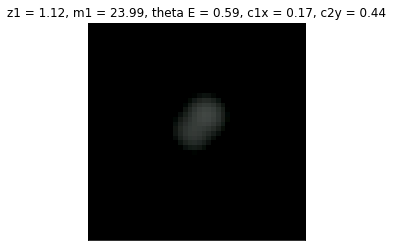

1.05,24.04,0.59,0.32,0.38,


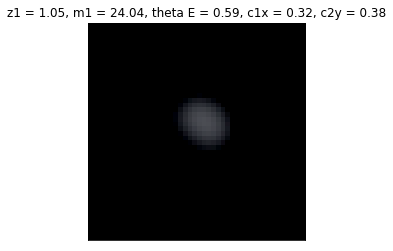

0.94,22.63,0.39,0.14,0.30,


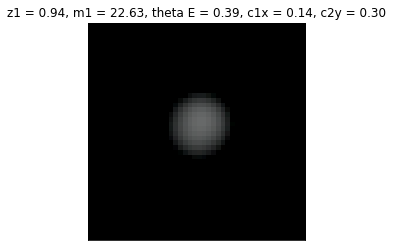

0.74,22.08,0.41,0.12,0.10,


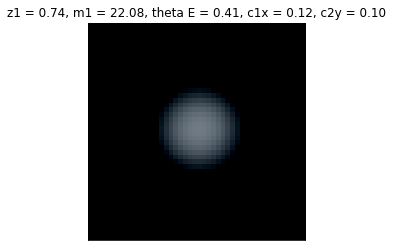

1.08,22.12,0.71,0.03,0.17,


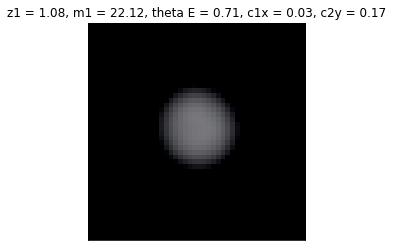

0.79,22.09,0.37,0.27,0.19,


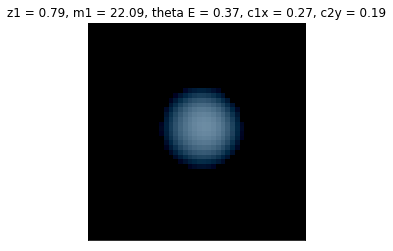

0.57,24.03,0.39,0.02,0.16,


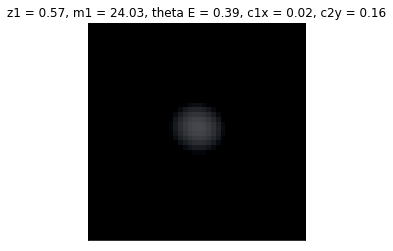

1.14,22.77,0.66,0.21,0.33,


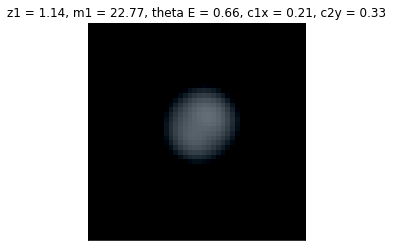

0.92,22.74,0.41,0.25,0.07,


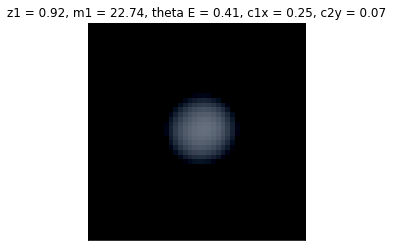

0.46,24.81,0.52,0.39,0.33,


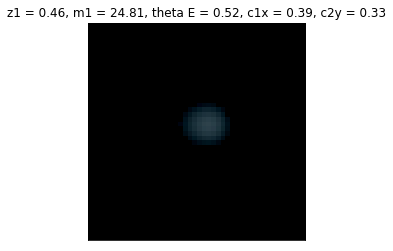

0.67,23.82,0.54,0.07,0.48,


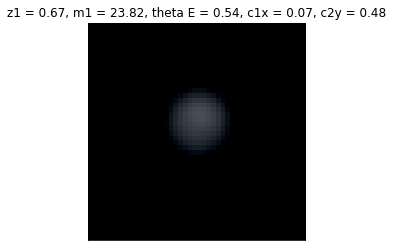

0.93,24.06,0.69,0.19,0.30,


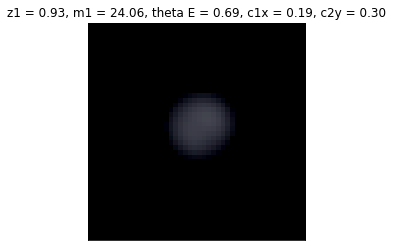

0.73,23.77,0.75,0.23,0.25,


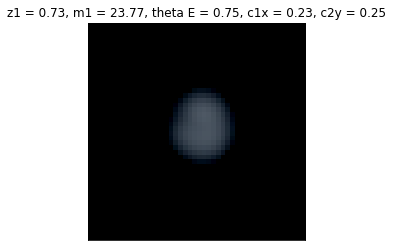

0.75,22.02,0.55,0.11,0.51,


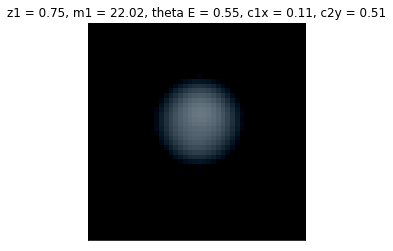

0.90,23.74,0.77,0.10,0.70,


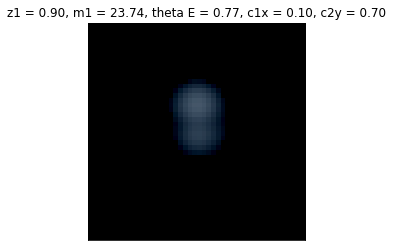

0.36,22.21,0.63,0.04,0.24,


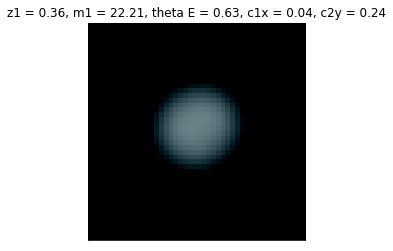

1.01,24.86,0.89,0.18,0.25,


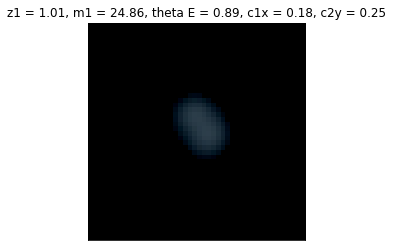

1.28,23.84,0.37,0.01,0.02,


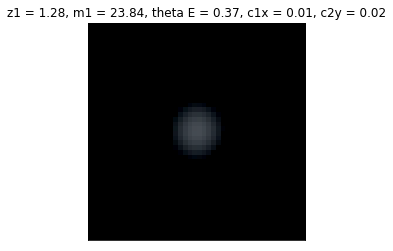

0.46,22.96,0.64,0.30,0.29,


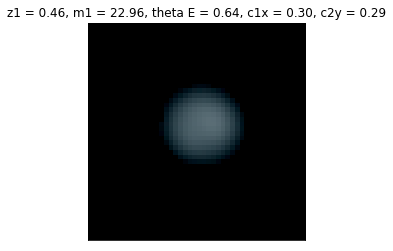

0.84,23.42,0.85,0.34,0.27,


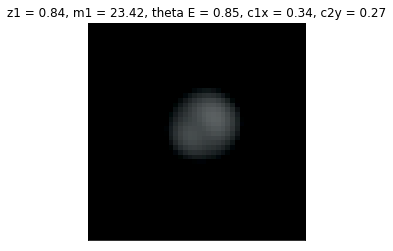

1.02,23.43,1.04,0.09,0.95,


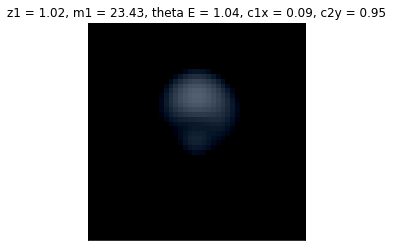

1.20,24.20,0.59,0.03,0.46,


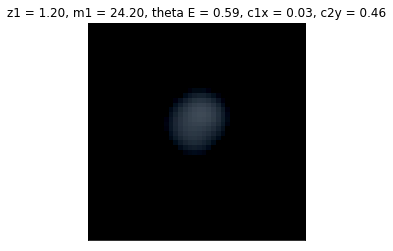

0.66,23.08,0.42,0.10,0.04,


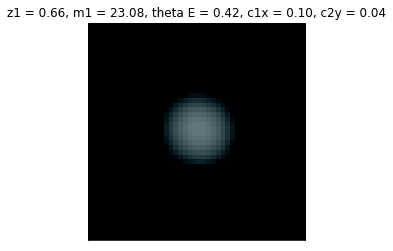

0.84,23.44,0.48,0.19,0.17,


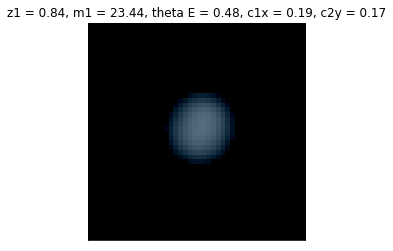

0.75,23.52,1.11,0.22,0.41,


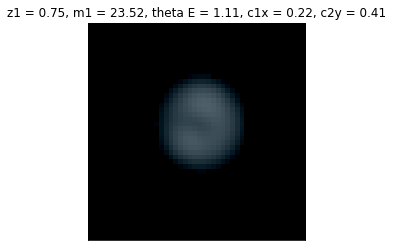

0.69,24.53,0.64,0.18,0.32,


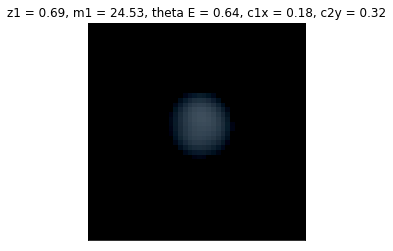

0.93,23.68,0.62,0.22,0.18,


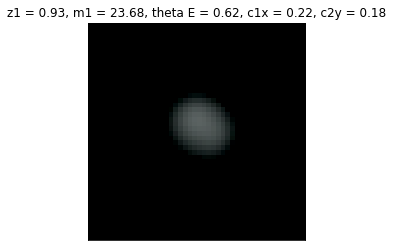

0.72,23.91,0.72,0.15,0.19,


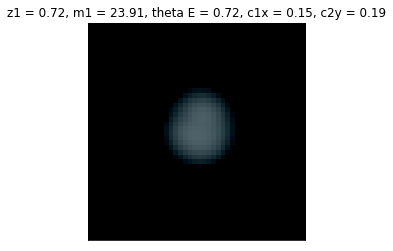

1.28,24.58,1.32,0.61,0.90,


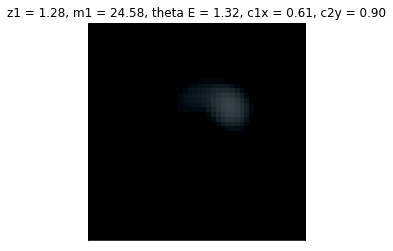

0.98,22.01,0.50,0.24,0.42,


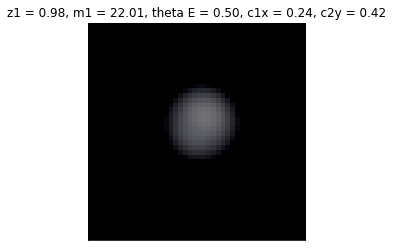

1.10,22.86,0.56,0.27,0.14,


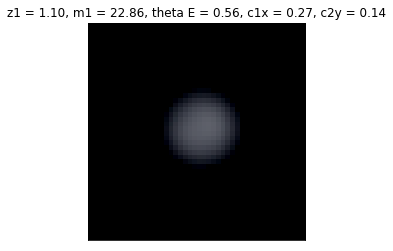

0.79,22.42,0.80,0.11,0.20,


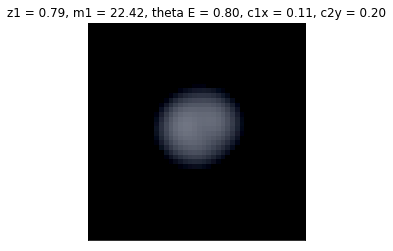

0.79,23.27,0.75,0.27,0.28,


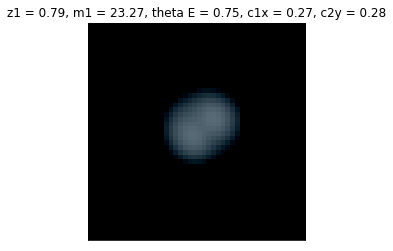

0.91,23.05,0.38,0.23,0.27,


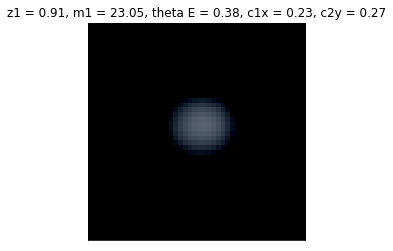

0.84,22.51,0.82,0.50,0.56,


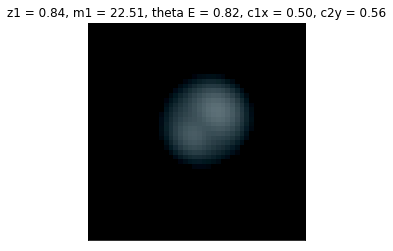

0.82,22.36,1.26,0.63,0.29,


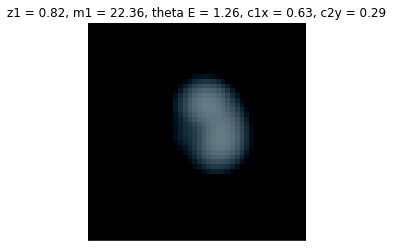

0.89,24.58,0.57,0.03,0.34,


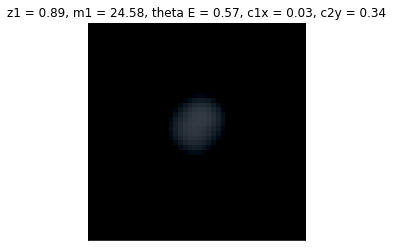

0.98,24.43,0.65,0.43,0.24,


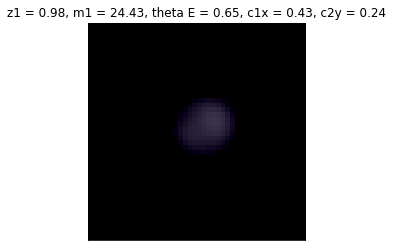

0.64,24.43,0.36,0.29,0.18,


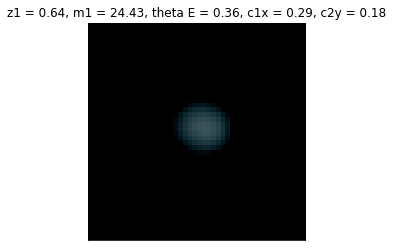

1.17,23.14,1.18,0.13,0.21,


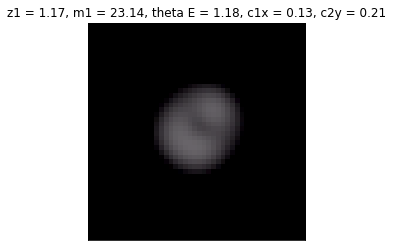

1.13,22.40,0.46,0.36,0.03,


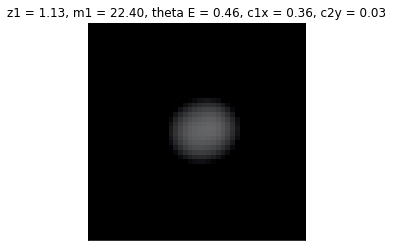

0.79,24.43,0.54,0.09,0.20,


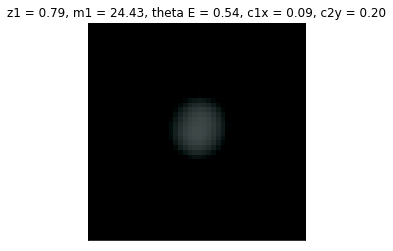

1.29,24.03,0.45,0.39,0.19,


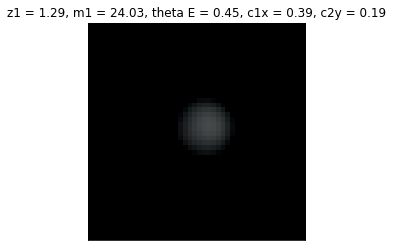

0.53,22.26,0.62,0.13,0.46,


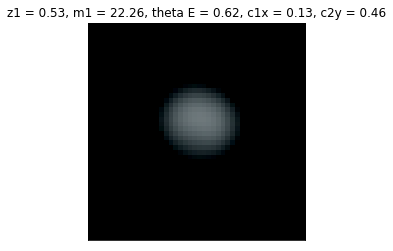

0.80,23.67,0.39,0.19,0.19,


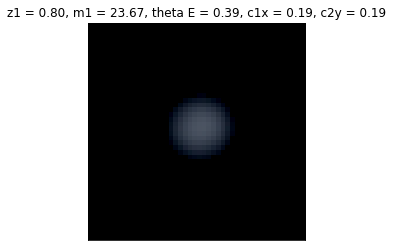

0.84,23.60,1.64,0.69,1.47,


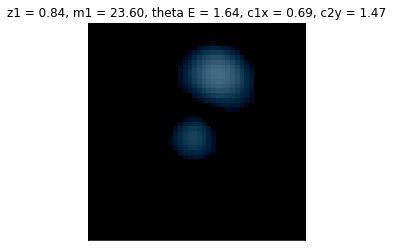

1.15,24.70,1.09,0.14,0.18,


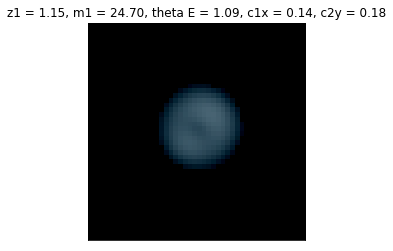

0.70,24.88,0.70,0.53,0.08,


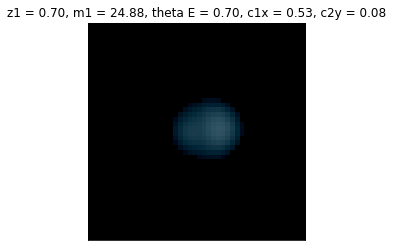

0.76,22.43,0.64,0.62,0.02,


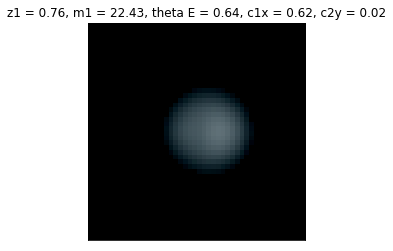

1.22,24.42,1.41,1.30,0.50,


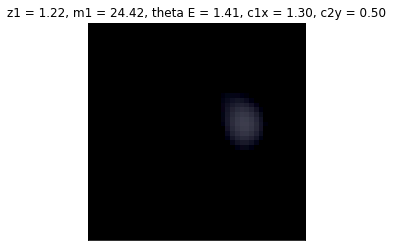

0.92,24.73,0.93,0.04,0.12,


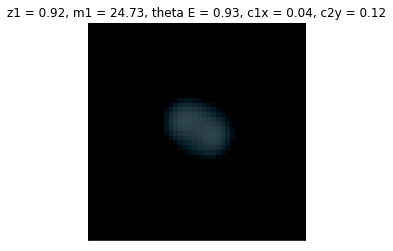

0.90,23.91,0.57,0.10,0.09,


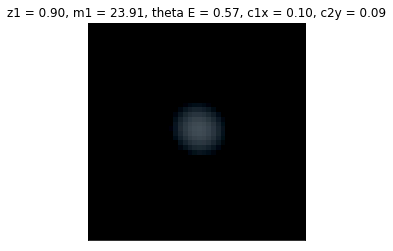

0.63,23.06,0.81,0.19,0.31,


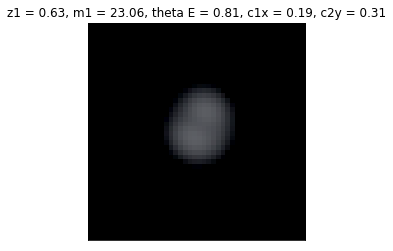

0.97,24.14,0.69,0.26,0.11,


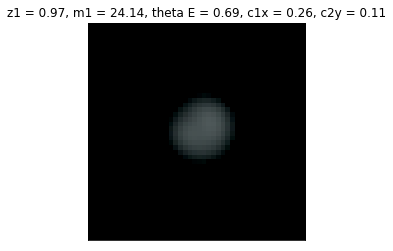

0.72,22.98,0.40,0.26,0.23,


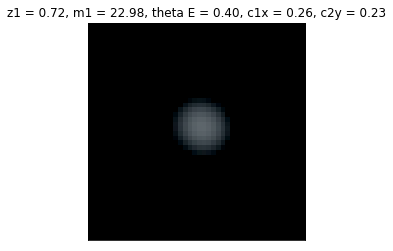

1.08,23.50,0.87,0.23,0.48,


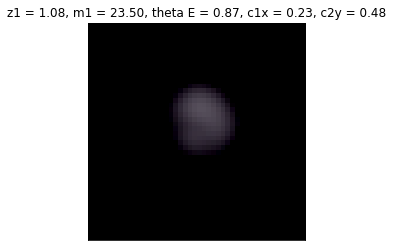

1.13,22.03,0.80,0.49,0.29,


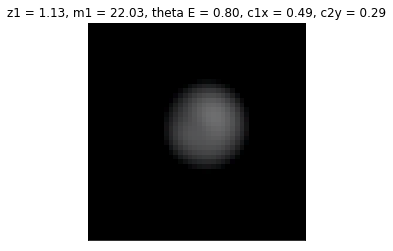

1.04,23.89,0.55,0.17,0.28,


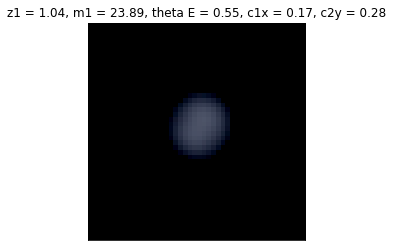

0.61,24.43,0.41,0.07,0.24,


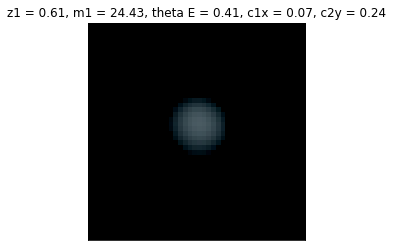

0.98,24.43,0.87,0.13,0.74,


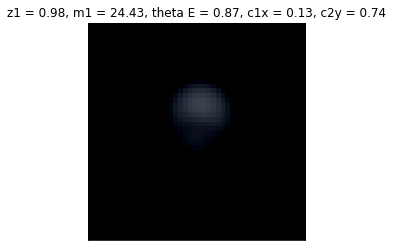

0.45,22.95,1.07,0.24,0.96,


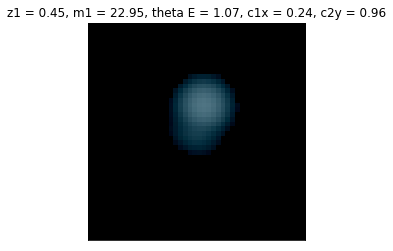

1.21,24.44,0.86,0.54,0.48,


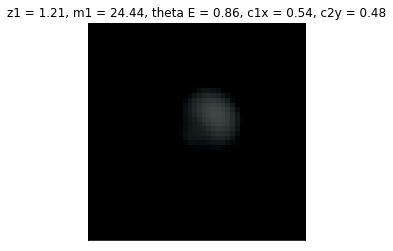

1.21,23.20,0.82,0.46,0.51,


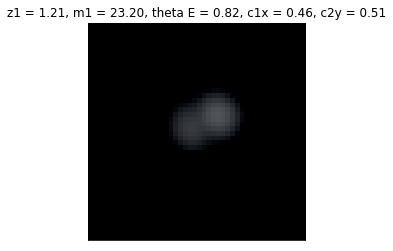

0.83,23.17,0.59,0.31,0.29,


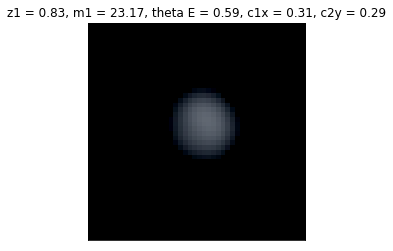

0.74,23.59,0.50,0.16,0.34,


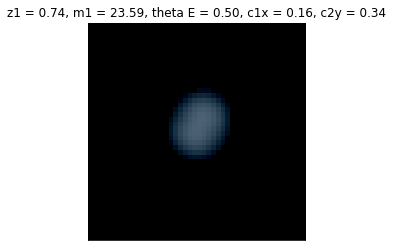

1.18,23.26,1.06,0.73,0.76,


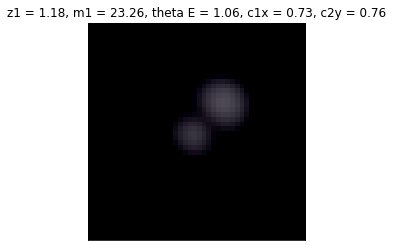

1.11,22.01,1.96,1.82,0.10,


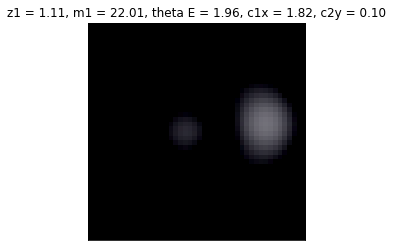

0.59,23.80,0.72,0.60,0.31,


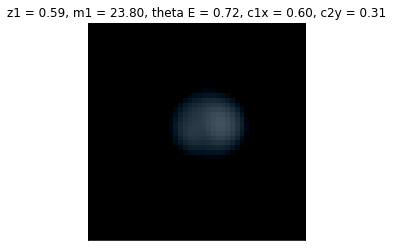

1.12,22.11,0.69,0.08,0.17,


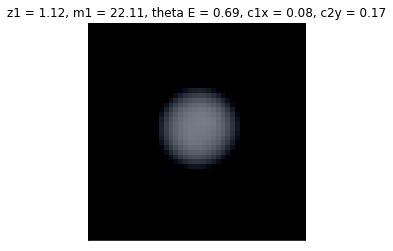

0.84,23.50,0.55,0.19,0.13,


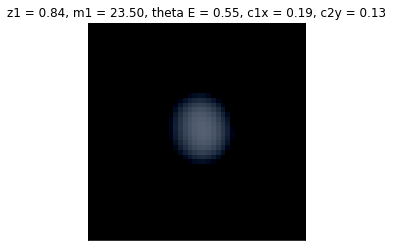

0.73,24.79,0.59,0.21,0.16,


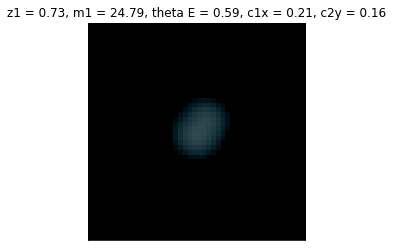

1.30,23.63,2.22,0.76,1.25,


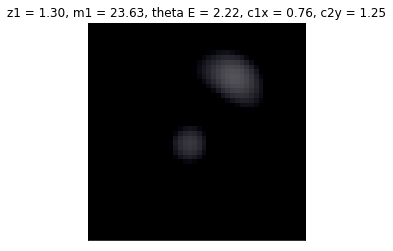

0.56,22.30,0.79,0.28,0.24,


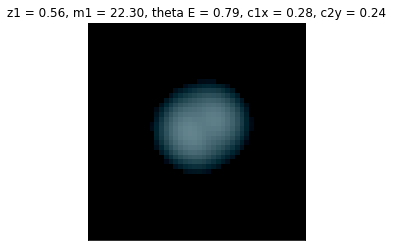

0.86,22.72,1.20,0.58,0.21,


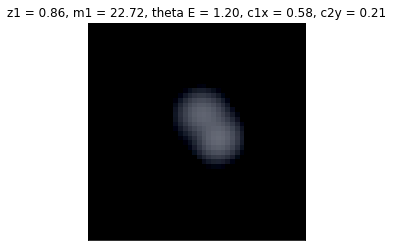

1.10,22.82,0.44,0.37,0.22,


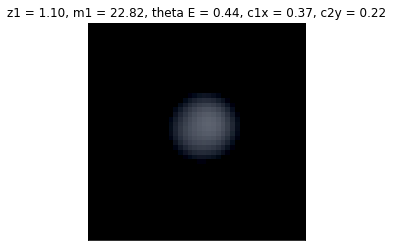

1.16,22.24,0.93,0.75,0.08,


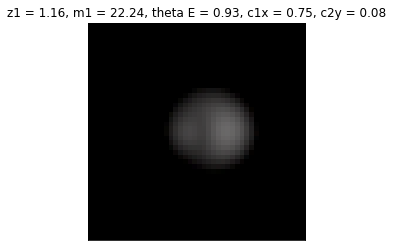

0.62,22.01,0.43,0.02,0.35,


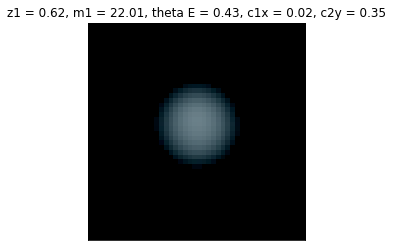

0.70,24.76,0.82,0.36,0.11,


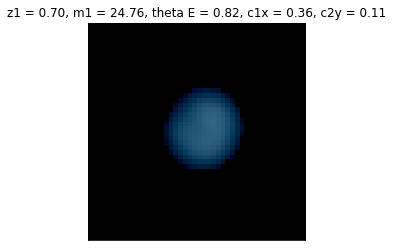

1.16,22.97,0.50,0.02,0.47,


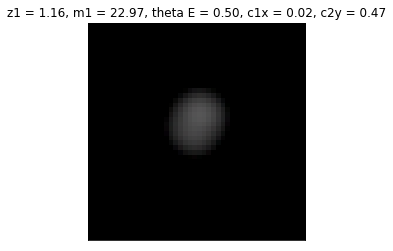

1.14,24.20,0.81,0.00,0.04,


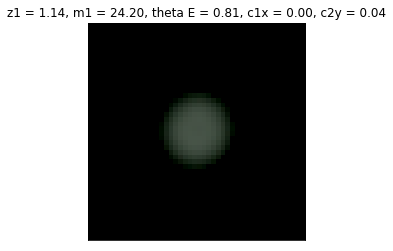

0.70,22.33,0.39,0.18,0.05,


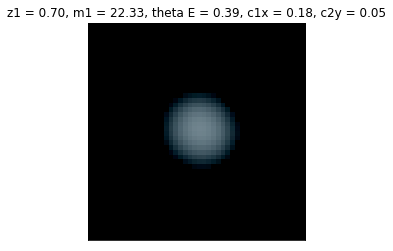

0.83,23.61,0.67,0.10,0.29,


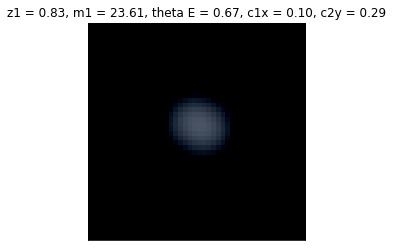

1.10,23.94,0.92,0.13,0.78,


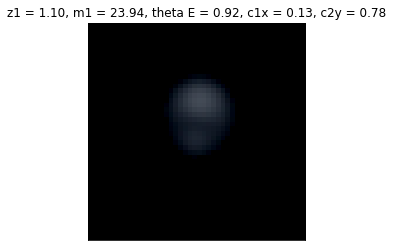

0.69,22.10,0.93,0.45,0.50,


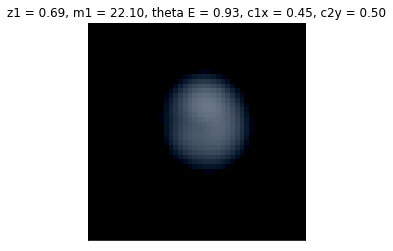

0.71,22.18,0.88,0.02,0.28,


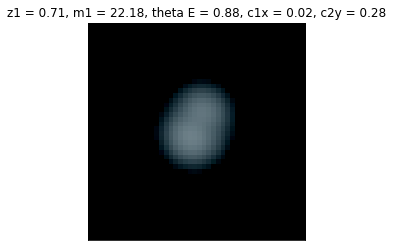

0.72,22.96,0.35,0.05,0.34,


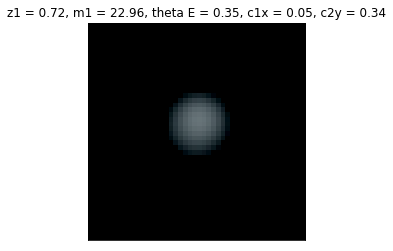

1.01,23.96,0.40,0.16,0.20,


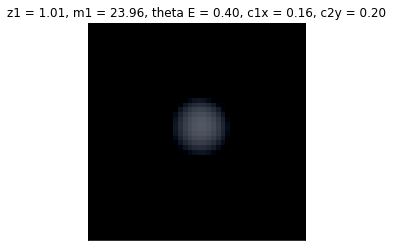

0.93,23.18,0.48,0.47,0.03,


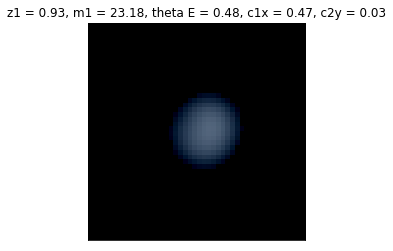

1.08,22.14,1.25,0.34,0.88,


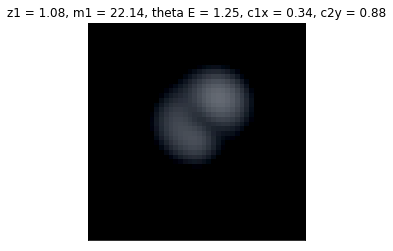

0.94,23.84,0.83,0.48,0.12,


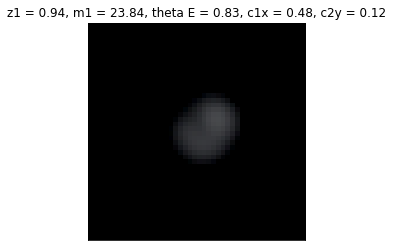

0.66,22.33,0.89,0.52,0.13,


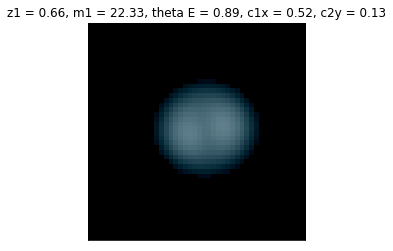

0.54,22.09,0.59,0.11,0.49,


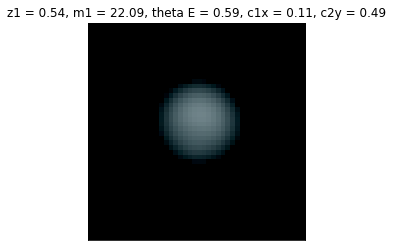

0.89,22.72,0.61,0.14,0.17,


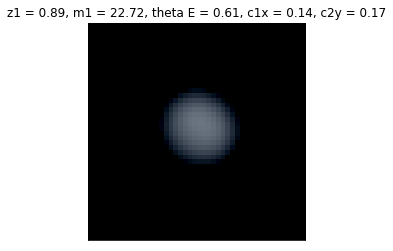

1.21,22.57,0.88,0.16,0.32,


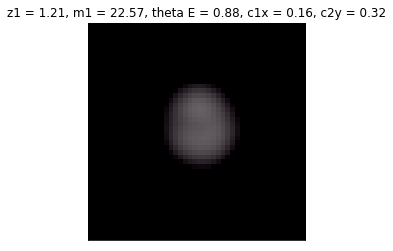

0.58,24.71,0.51,0.21,0.21,


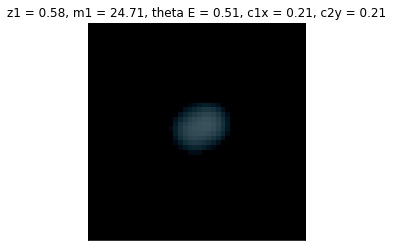

1.21,22.35,0.42,0.02,0.07,


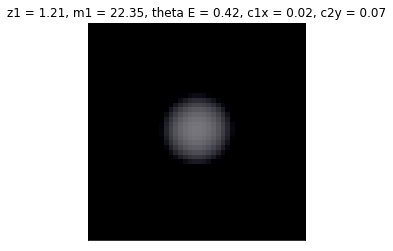

1.05,23.88,0.99,0.71,0.37,


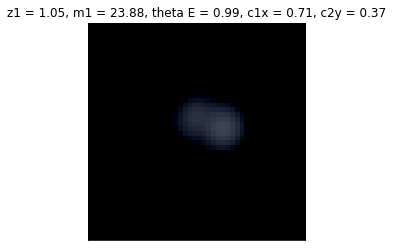

1.23,23.00,0.91,0.49,0.32,


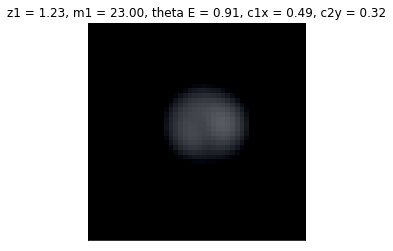

0.56,23.50,0.94,0.01,0.15,


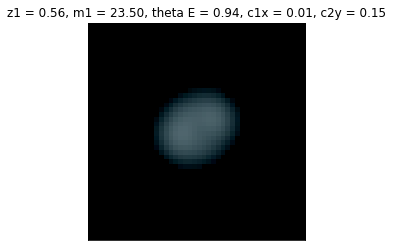

0.92,24.75,1.36,0.66,1.18,


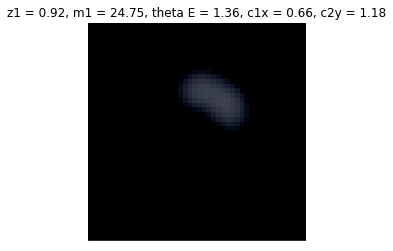

0.96,23.43,0.64,0.42,0.06,


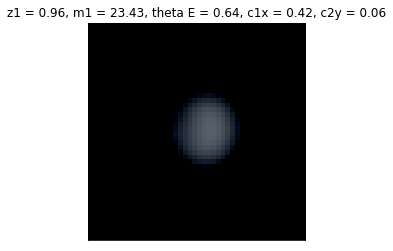

1.11,23.23,1.43,0.14,0.41,


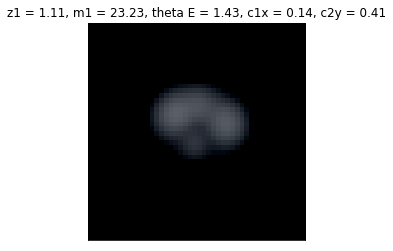

0.85,23.27,0.50,0.17,0.31,


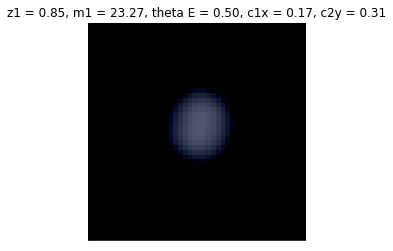

0.81,23.00,0.57,0.33,0.00,


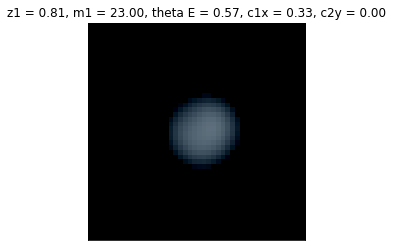

0.99,22.12,0.83,0.01,0.25,


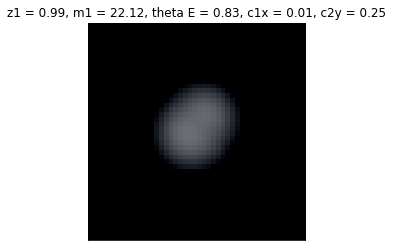

1.06,22.12,0.52,0.02,0.49,


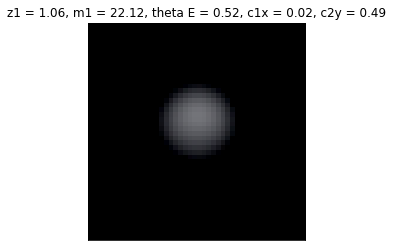

0.67,22.63,0.53,0.30,0.34,


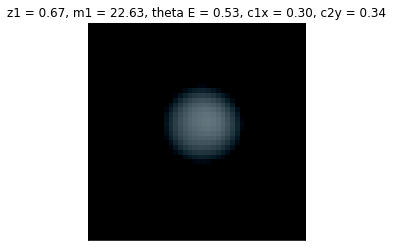

1.03,23.55,0.61,0.05,0.37,


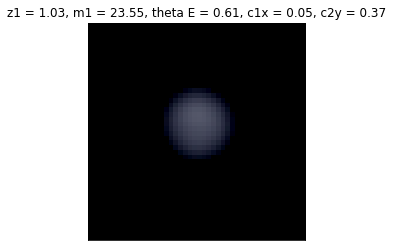

0.70,22.70,0.40,0.25,0.19,


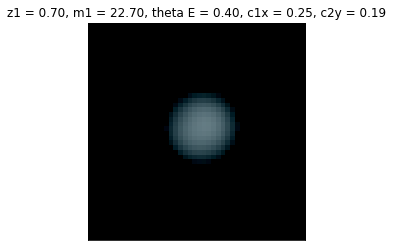

0.82,22.85,0.65,0.27,0.23,


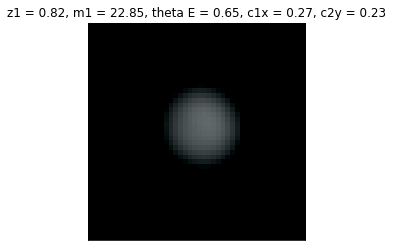

1.23,22.79,1.02,0.75,0.25,


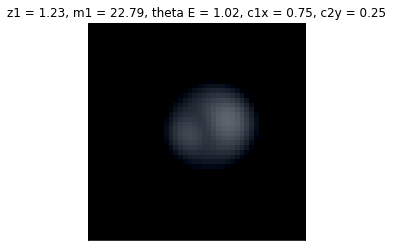

0.59,22.87,0.52,0.42,0.12,


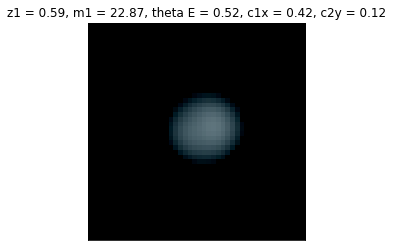

0.80,23.39,0.70,0.51,0.14,


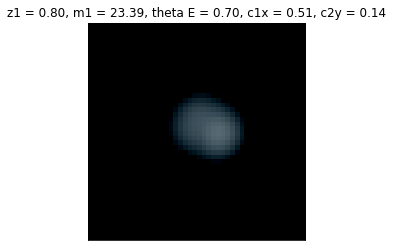

0.93,23.59,0.58,0.01,0.49,


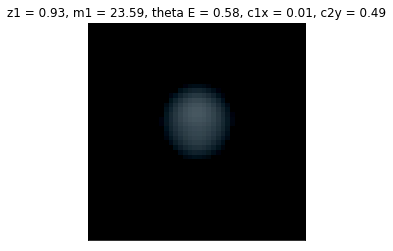

0.53,23.21,0.49,0.36,0.05,


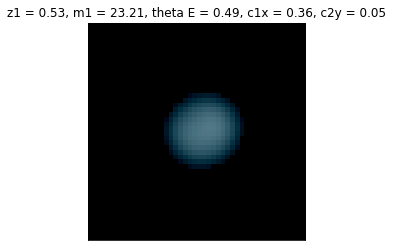

0.73,24.11,0.56,0.25,0.20,


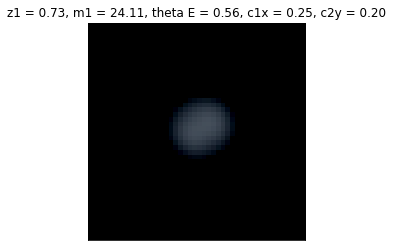

0.88,22.23,1.14,0.34,0.51,


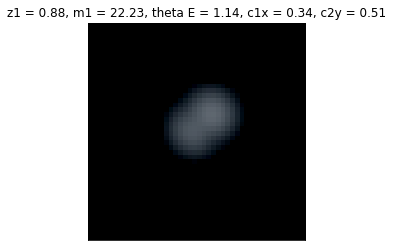

0.74,22.93,0.72,0.49,0.37,


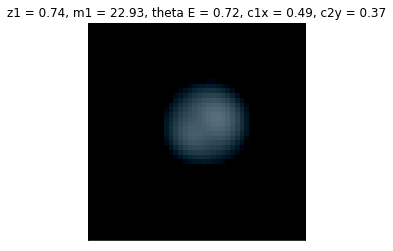

0.95,22.39,0.50,0.28,0.06,


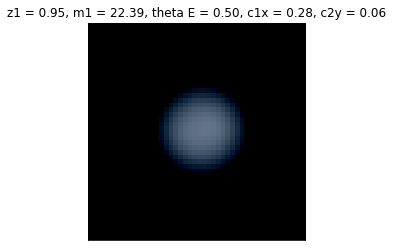

0.68,22.46,1.35,1.18,0.11,


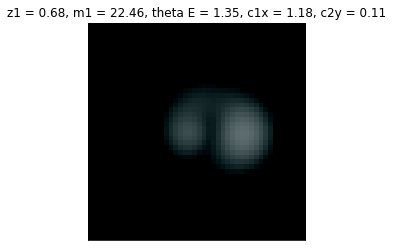

0.77,23.16,0.57,0.12,0.53,


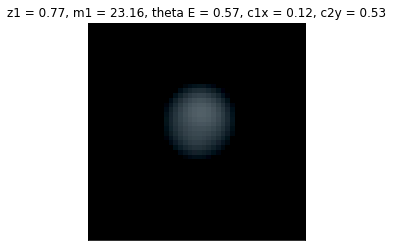

0.75,22.68,0.60,0.01,0.49,


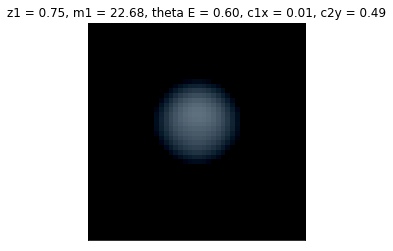

0.44,23.27,1.08,0.06,0.46,


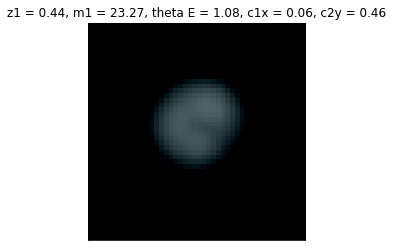

0.76,24.78,0.46,0.15,0.09,


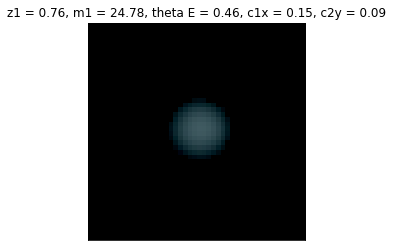

1.17,22.65,0.66,0.40,0.31,


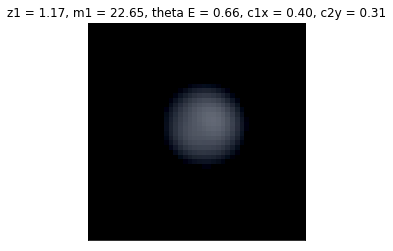

0.65,22.61,1.00,0.32,0.81,


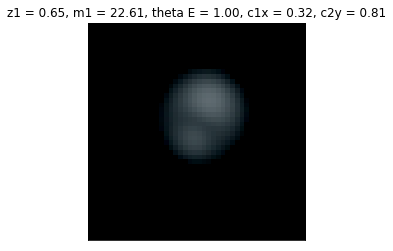

0.61,23.36,0.44,0.28,0.28,


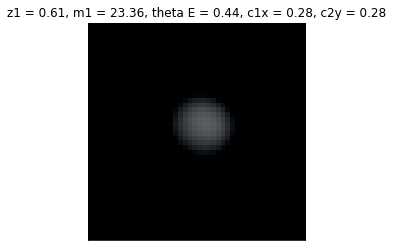

0.57,24.34,0.63,0.38,0.08,


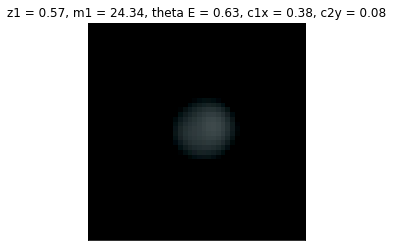

1.14,23.04,0.55,0.44,0.13,


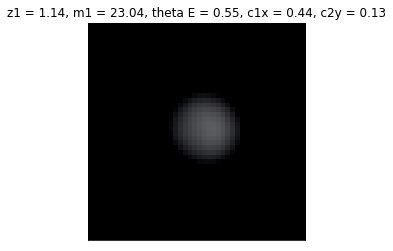

0.90,23.53,0.69,0.47,0.17,


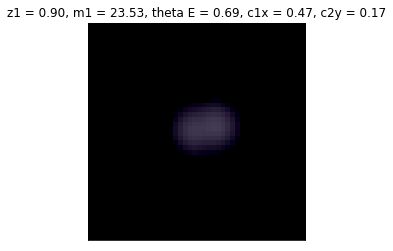

1.05,23.52,0.67,0.34,0.40,


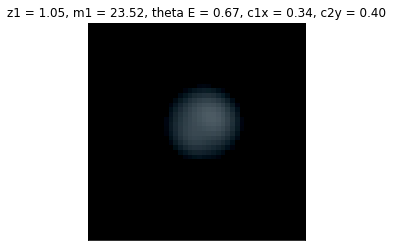

1.12,24.42,0.70,0.25,0.24,


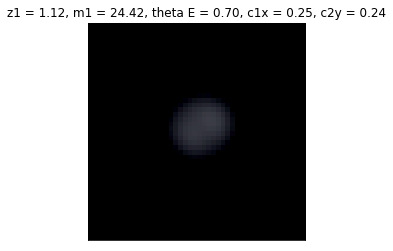

0.91,22.42,0.64,0.60,0.21,


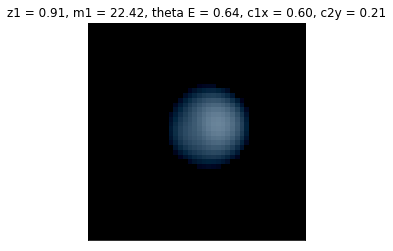

1.13,22.67,0.37,0.15,0.09,


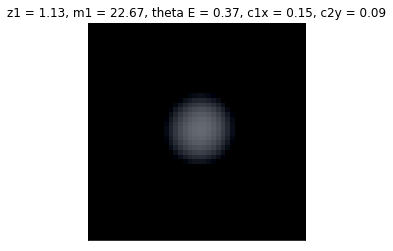

0.95,23.25,0.61,0.07,0.53,


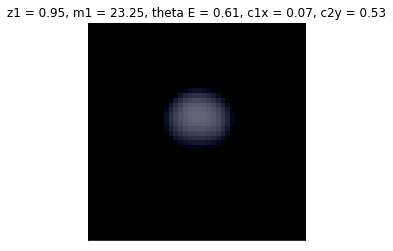

1.07,22.77,1.40,0.30,1.22,


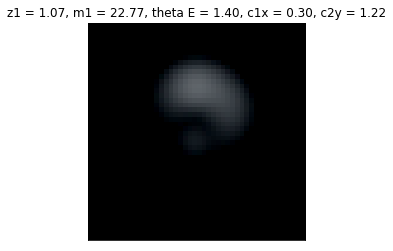

0.66,22.24,0.45,0.24,0.15,


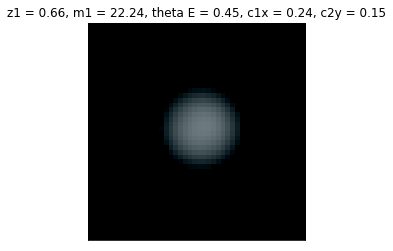

0.99,24.81,0.85,0.51,0.56,


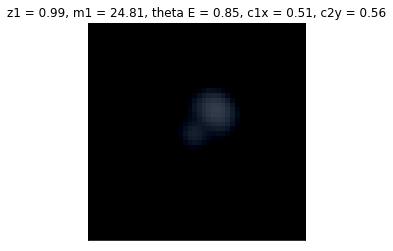

0.58,23.81,0.39,0.18,0.29,


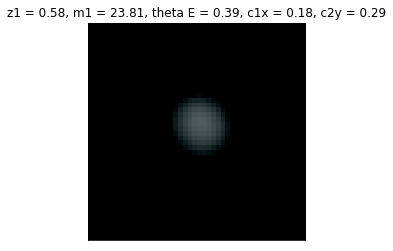

0.89,24.71,0.82,0.30,0.38,


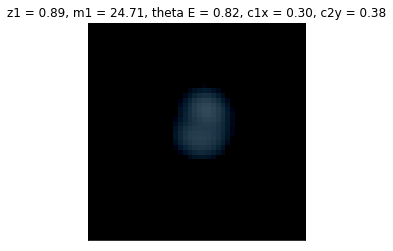

0.90,24.30,0.39,0.06,0.27,


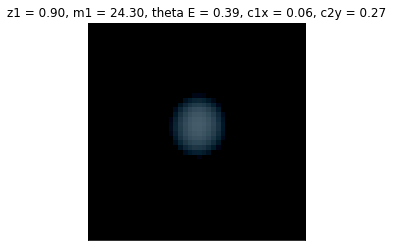

0.87,22.28,0.80,0.42,0.30,


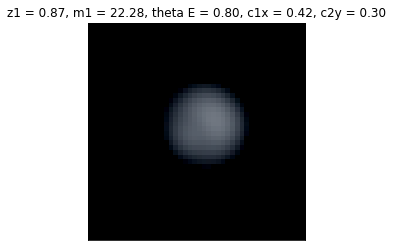

0.91,24.73,0.75,0.03,0.73,


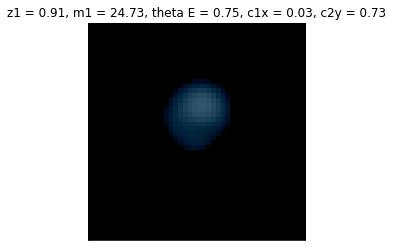

0.41,22.77,0.93,0.76,0.44,


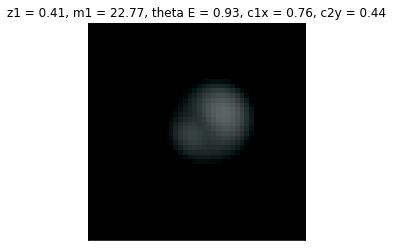

0.91,24.77,0.60,0.20,0.34,


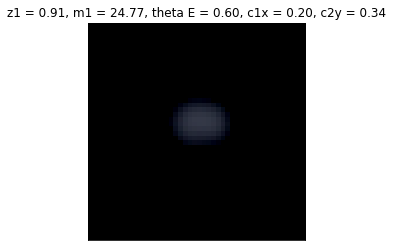

1.00,22.57,1.40,1.19,0.38,


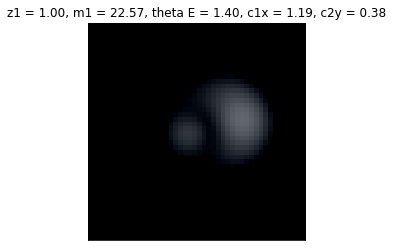

0.82,23.61,0.94,0.10,0.02,


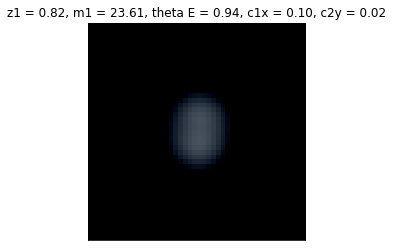

0.78,22.48,0.50,0.18,0.37,


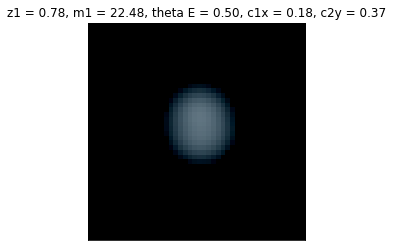

1.22,23.63,0.43,0.19,0.27,


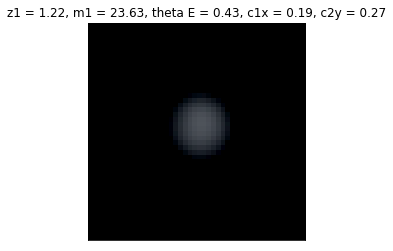

1.17,24.59,0.86,0.14,0.35,


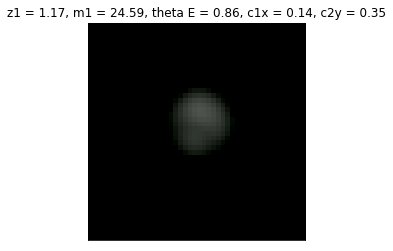

0.80,24.37,0.44,0.14,0.01,


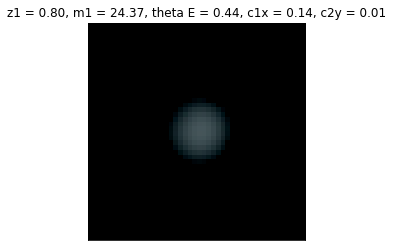

0.87,24.73,1.22,0.38,0.90,


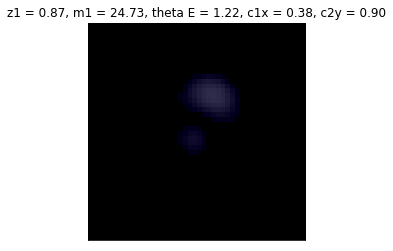

1.05,23.87,1.00,0.42,0.37,


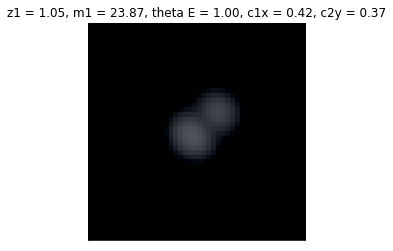

0.92,23.33,0.65,0.49,0.37,


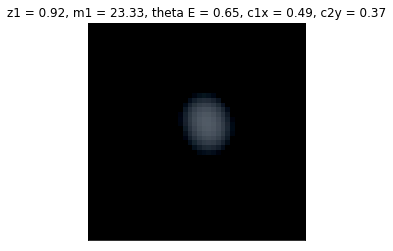

1.14,23.20,1.04,0.96,0.12,


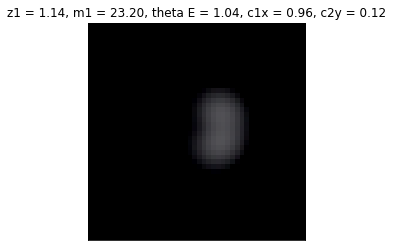

0.57,23.25,0.45,0.15,0.03,


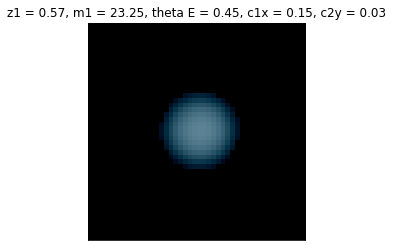

1.09,23.01,0.66,0.20,0.49,


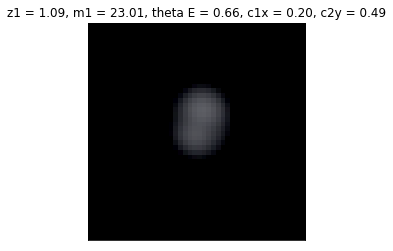

0.91,24.05,0.67,0.25,0.29,


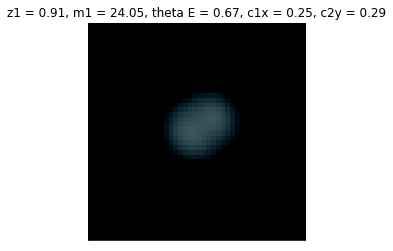

0.93,24.70,0.52,0.07,0.05,


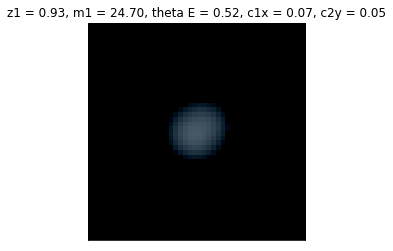

1.09,23.75,0.68,0.29,0.26,


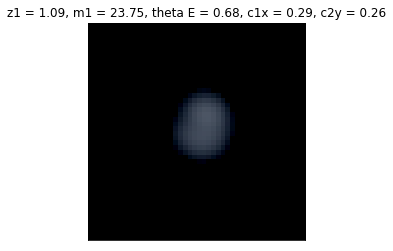

0.73,22.80,0.43,0.37,0.19,


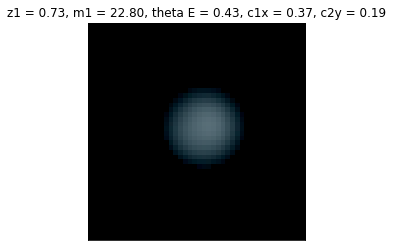

0.90,23.09,1.17,0.96,0.07,


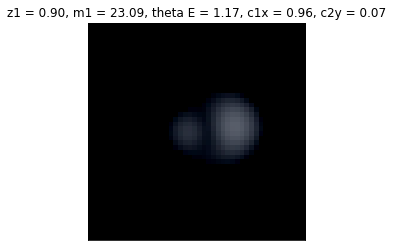

0.96,22.09,1.04,0.99,0.26,


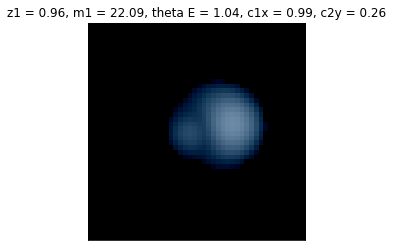

1.12,24.65,0.77,0.28,0.69,


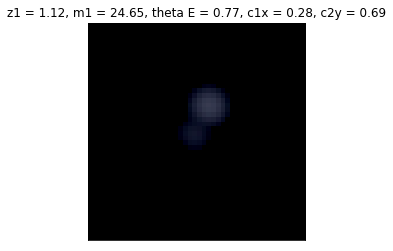

1.20,23.31,0.53,0.04,0.07,


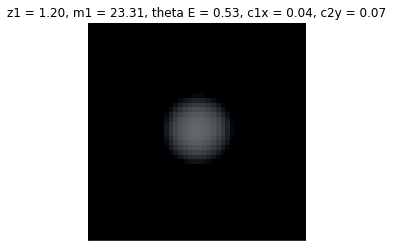

0.93,24.66,0.39,0.04,0.00,


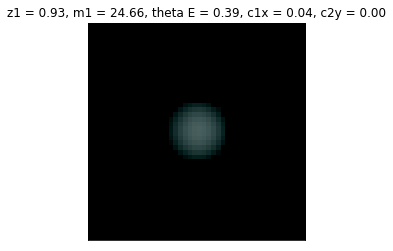

0.71,22.45,0.37,0.36,0.07,


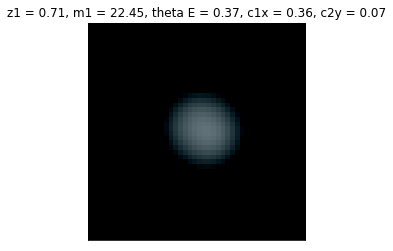

1.04,22.12,1.25,0.11,0.22,


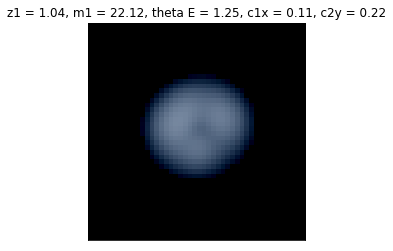

0.93,24.81,0.70,0.13,0.68,


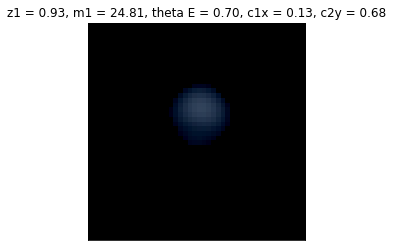

0.80,23.71,0.76,0.15,0.64,


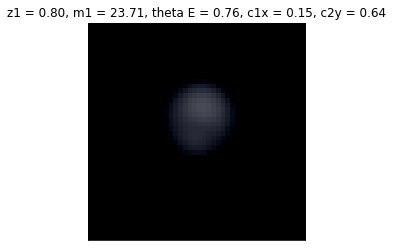

0.58,23.55,0.64,0.20,0.13,


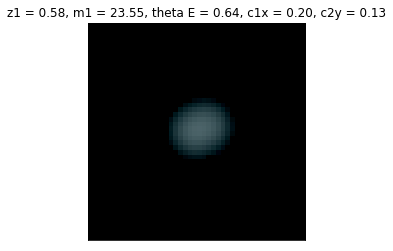

0.83,24.58,1.06,0.35,0.00,


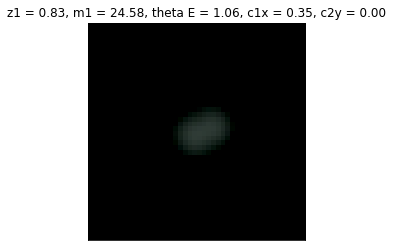

0.84,23.41,1.12,0.84,0.28,


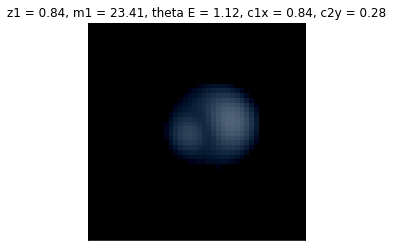

0.99,23.00,1.57,0.25,1.54,


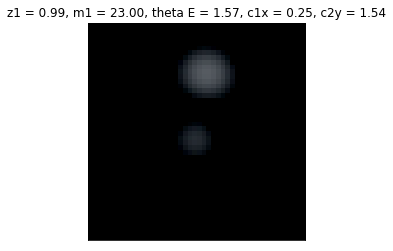

0.97,23.60,0.93,0.61,0.26,


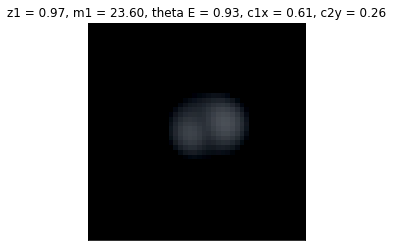

1.03,24.48,0.37,0.23,0.08,


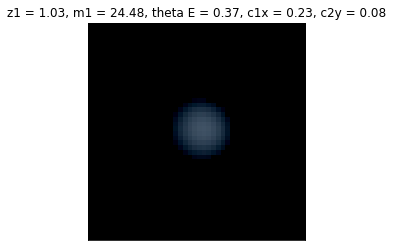

0.83,24.74,0.47,0.23,0.16,


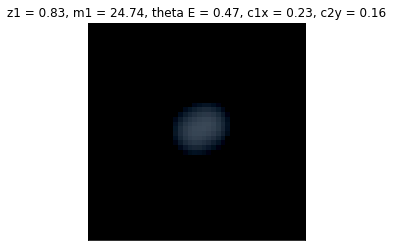

1.05,23.39,0.41,0.34,0.18,


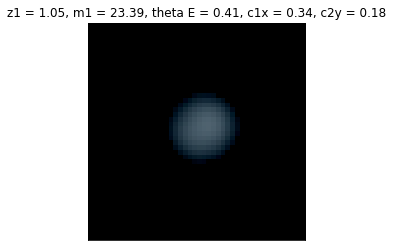

0.75,24.00,0.40,0.33,0.17,


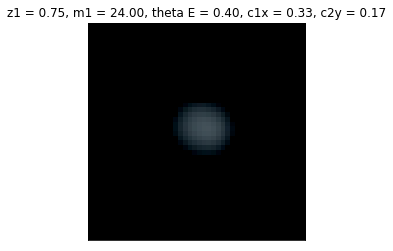

1.04,22.69,0.43,0.40,0.02,


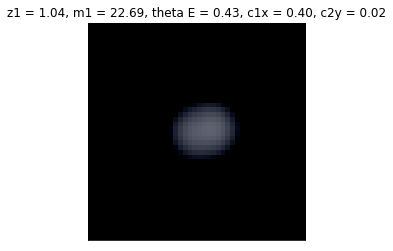

1.02,24.49,1.14,0.85,0.38,


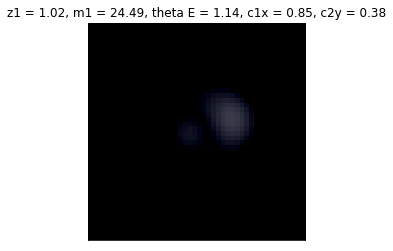

1.00,24.35,1.01,0.93,0.21,


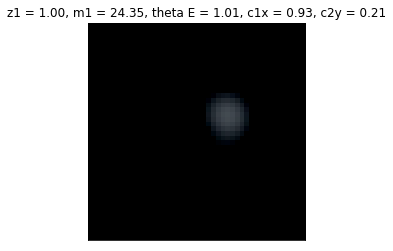

0.76,23.68,1.39,0.25,0.68,


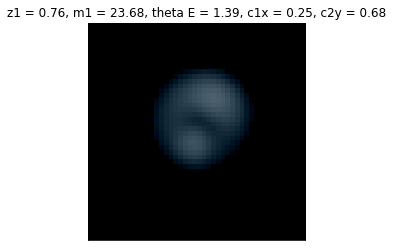

0.93,23.91,0.80,0.16,0.03,


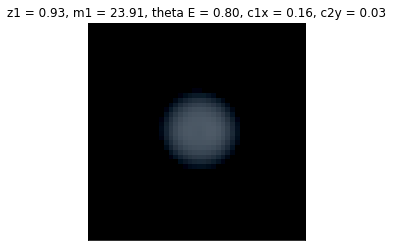

0.70,22.17,0.52,0.13,0.04,


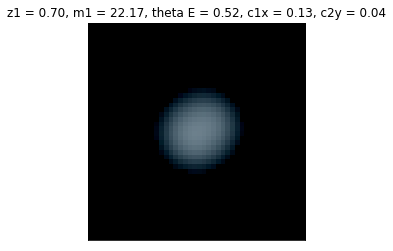

0.71,24.04,0.59,0.44,0.21,


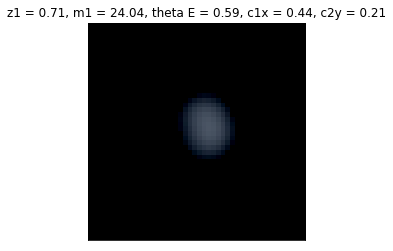

0.43,24.02,0.38,0.25,0.10,


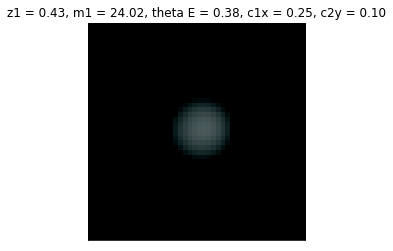

0.49,24.12,1.02,0.12,0.43,


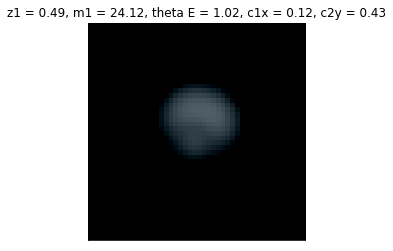

0.38,24.53,0.40,0.20,0.23,


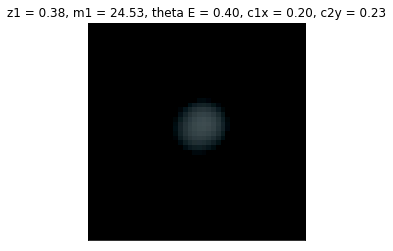

0.69,24.18,0.44,0.34,0.13,


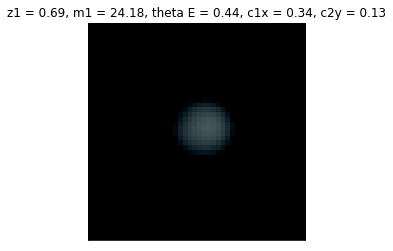

0.88,24.68,0.85,0.22,0.62,


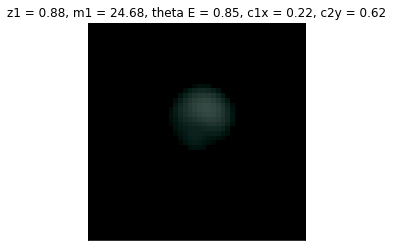

1.20,22.15,1.55,0.31,0.70,


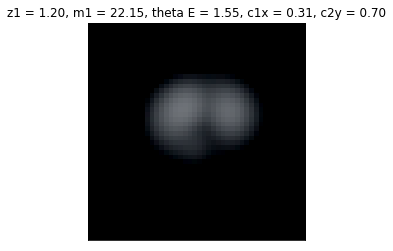

0.35,23.80,0.51,0.39,0.19,


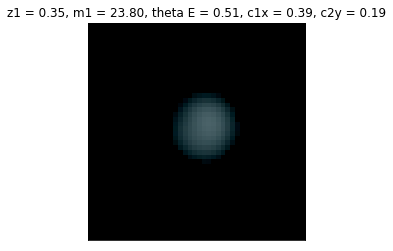

0.85,22.30,0.62,0.39,0.15,


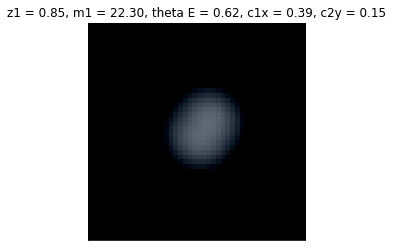

0.91,23.06,0.76,0.36,0.61,


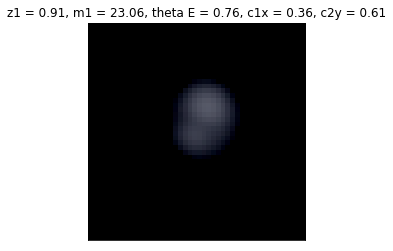

1.27,22.79,1.42,0.71,0.28,


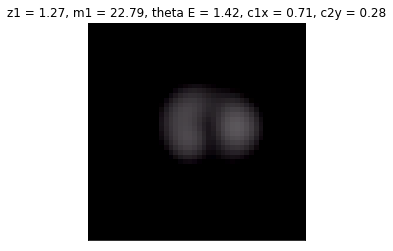

1.11,22.06,1.28,0.41,0.42,


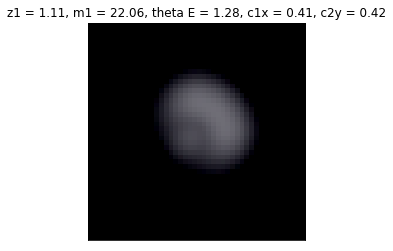

1.01,24.31,0.75,0.60,0.06,


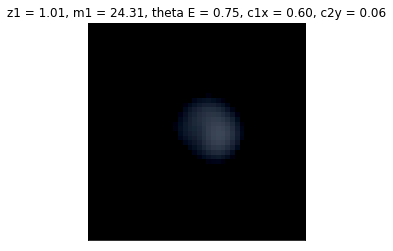

0.91,23.11,0.65,0.17,0.09,


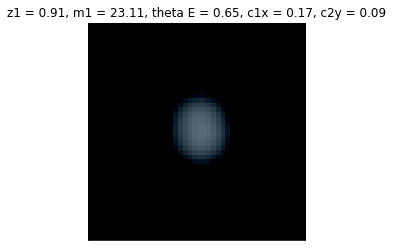

In [9]:
simulations_from_data(500, False)

In [10]:
#! convert -delay 50 -loop 0 *.png Only_sources_data.gif
#! rm *.png

In [11]:
#print(radii)

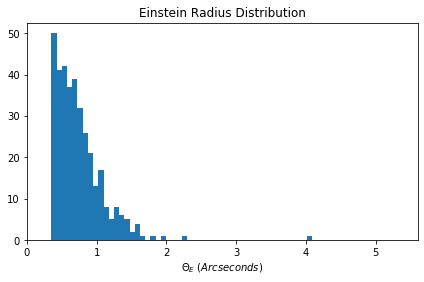

In [12]:
plt.figure(figsize=(7,4))
plt.hist(radii, 50)
plt.title('Einstein Radius Distribution')
plt.xlabel(r'$\Theta_E\ (Arc seconds)$')
plt.xlim(0,5.6)
plt.show()